In [2]:
setwd(path.expand("~/data/jupyternotebooks/"))

Jiangli Gui r0867437

In [3]:
dir.create("Assignment1")

Warning message in dir.create("Assignment1"):
“'Assignment1' already exists”


In [4]:
setwd("Assignment1")

In [5]:
getwd()

[1] "/mnt/storage/r0867437/jupyternotebooks/Assignment1"

In [6]:
rm(list = ls())
options(stringsAsFactors=FALSE)

library(Seurat)
library(dplyr)
library(Matrix)
library(SCopeLoomR)
library(IRdisplay)
library(plyr)
library(patchwork)
library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘SCopeLoomR’


The following object is masked from ‘package:base’:

    flush


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize




# Data description

Data comes form the paper "Establishment of a Prognostic Model of Lung Adenocarcinoma Based on Tumor Heterogeneity". 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9035852/

You can find single cell data by GSE117570 in GEO ncbi.
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE117570

The aim for this paper is to identify genes that are responsible for heterogeneity of lung adenocarcinoma(LUAD). The single cells come from 8 individuals with 4 normal and 4 tumor with a reading depth of 10× genomics based on Illumina NextSeq 500. However only data from 3 samples(GSM3304007, GSM3304011 and GSM3304013) were used to do the scRNA-seq analysis and trajectory analysis as downstream analysis.

So in this analysis, the data was picked and analysed to reproduce the result from the paper hopefully.

In [7]:
f <- dir()
f

[1] "GSM3304007_P1_Tumor_processed_data.txt.gz"
[2] "GSM3304011_P3_Tumor_processed_data.txt.gz"
[3] "GSM3304013_P4_Tumor_processed_data.txt.gz"

In [8]:
s = str_split(f,"_",simplify = T)[,1];s

[1] "GSM3304007" "GSM3304011" "GSM3304013"

### integrating 3 seperate files
read these 3 files, 'GSM3304007''GSM3304011''GSM3304013', cells with more than 5% mitochondrial genes were filtered out at the same time

In [9]:
scelist = list()
for(i in 1:length(f)){
  tmp = read.table(f[[i]], check.names = F)
  tmp = as.matrix(tmp)

  scelist[[i]] <- CreateSeuratObject(counts = tmp, 
                           project = s[[i]], 
                           min.cells = 3, 
                           min.features = 50)
  print(dim(scelist[[i]]))
  scelist[[i]][["percent.mt"]] <- PercentageFeatureSet(scelist[[i]], pattern = "^MT-")
  scelist[[i]] <- subset(scelist[[i]], subset = percent.mt < 5)
  print(dim(scelist[[i]]))
}


[1] 6611 1832
[1] 6611 1466
[1] 3211  328
[1] 3211  116
[1] 7492 1423
[1] 7492  281


### Integrate 3 files by CAA
normalize data at the same time

https://satijalab.org/seurat/articles/integration_rpca.html

In [10]:
for (i in 1:length(scelist)) {
  scelist[[i]] <- NormalizeData(scelist[[i]], verbose = FALSE)
  scelist[[i]] <- FindVariableFeatures(scelist[[i]],verbose = FALSE,nfeatures = 8000)
}
features <- SelectIntegrationFeatures(object.list = scelist)
scelist <- lapply(X = scelist, FUN = function(x) {
    x <- ScaleData(x, features = features, verbose = FALSE)
    x <- RunPCA(x, features = features, verbose = FALSE)
})
sce.anchors <- FindIntegrationAnchors(object.list = scelist, anchor.features = features, reduction = "rpca")
sce.integrated <- IntegrateData(anchorset = sce.anchors)
seurat_object <- sce.integrated

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Scaling features for provided objects

Computing within dataset neighborhoods

Finding all pairwise anchors

Finding neighborhoods

Finding anchors

	Found 271 anchors

Finding neighborhoods

Finding anchors

	Found 368 anchors

Finding neighborhoods

Finding anchors

	Found 250 anchors

Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 3 into 1 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
“Adding a command log without an assay associated with it”


## Quality control and filtering


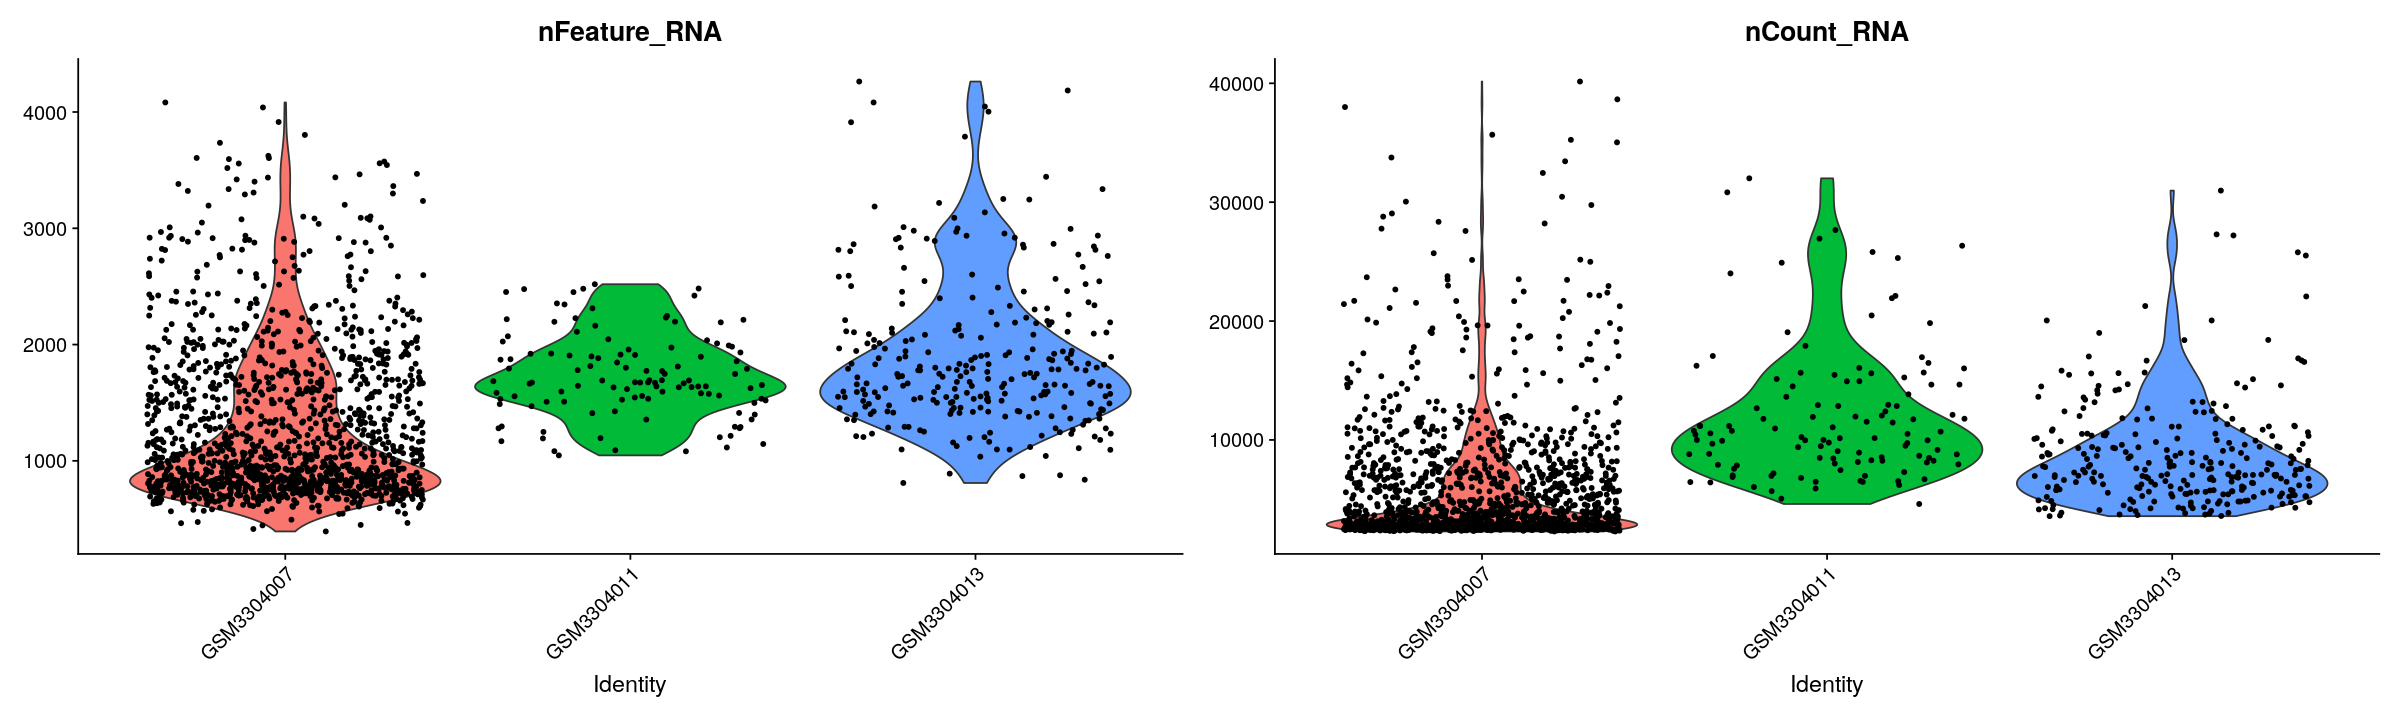

In [11]:
seurat_object <- sce.integrated
options(repr.plot.width=20, repr.plot.height=6) # To set the figure size
VlnPlot(object = seurat_object, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)

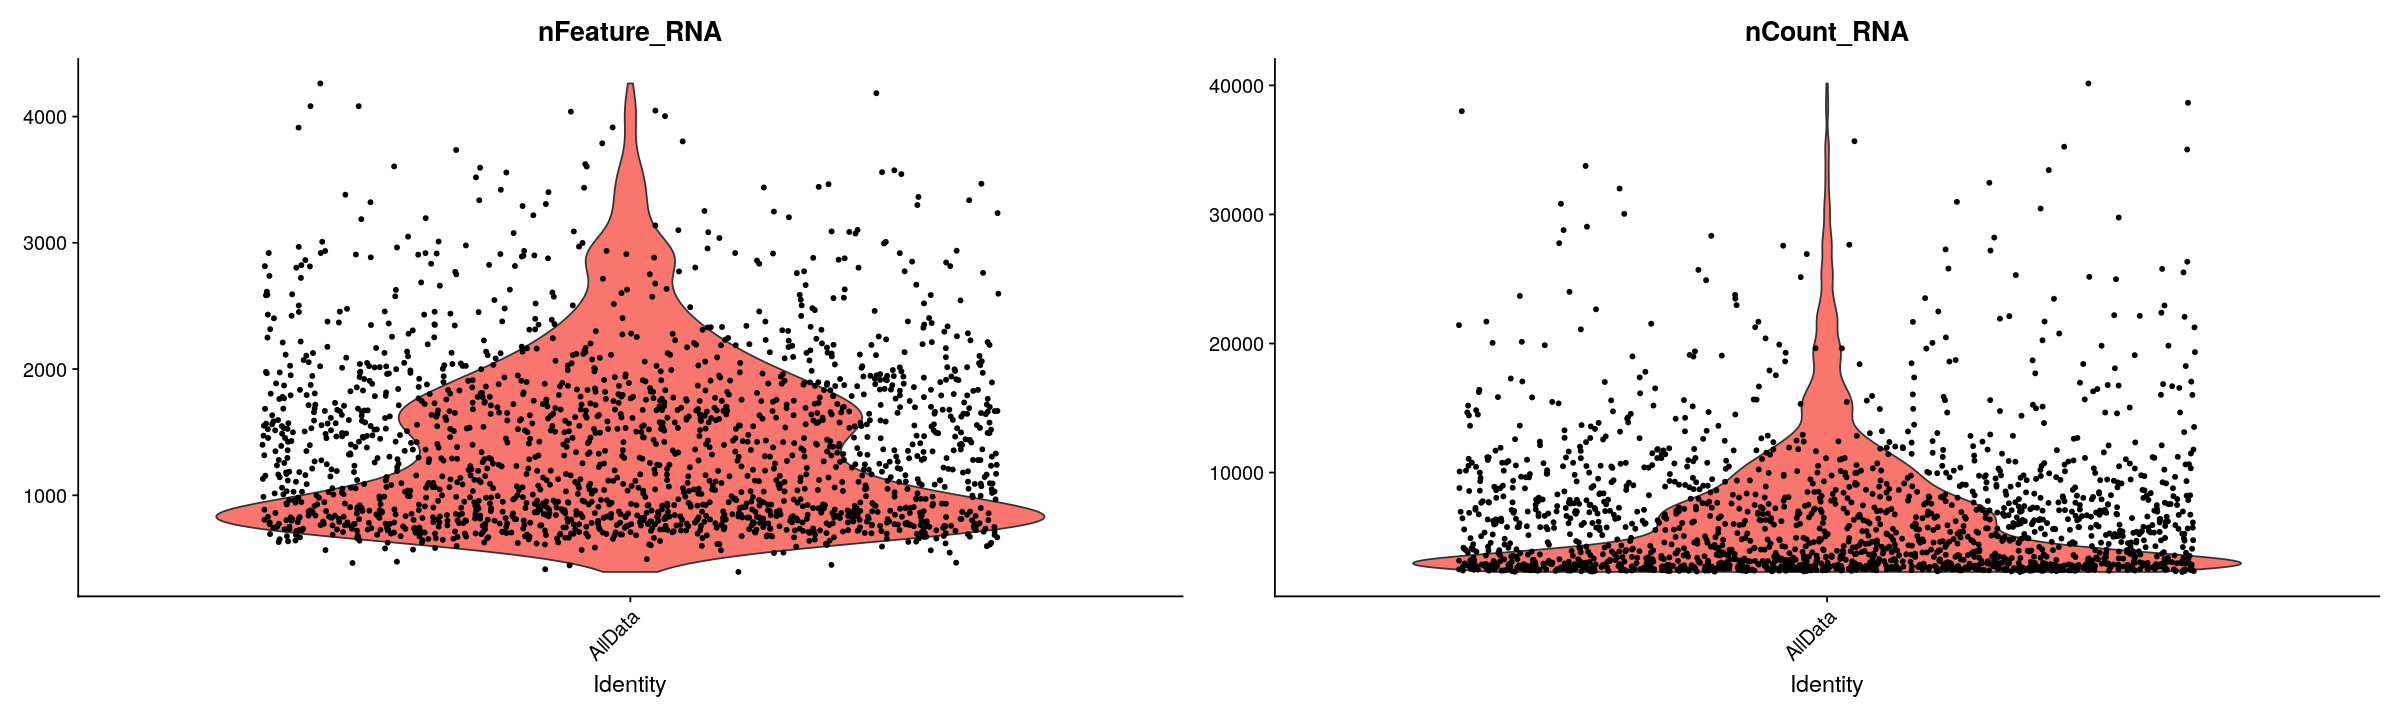

In [12]:
seurat_object[['AllData']] <- 'AllData'
options(repr.plot.width=20, repr.plot.height=6) # To set the figure size
VlnPlot(object = seurat_object, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2, group.by='AllData')

In [13]:
summary(seurat_object@meta.data$nFeature_RNA)
summary(seurat_object@meta.data$nCount_RNA)
seurat_object

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    393     858    1279    1423    1798    4262 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2303    2927    4922    6745    8476   40149 

An object of class Seurat 
10013 features across 1863 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA

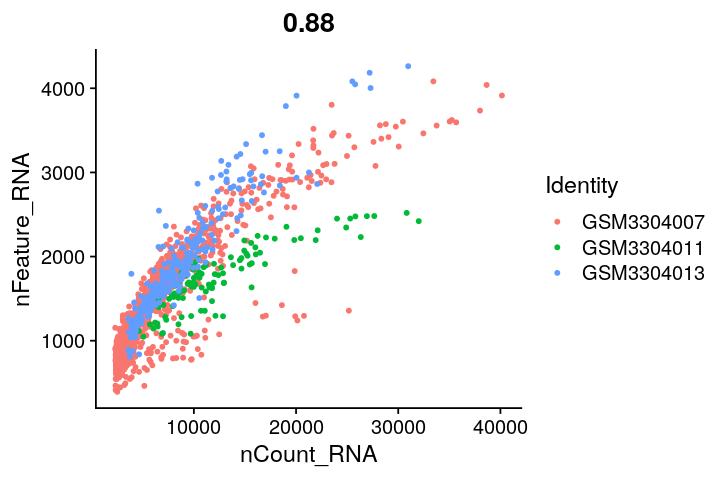

In [14]:
options(repr.plot.width=6, repr.plot.height=4)
FeatureScatter(object = seurat_object, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

In [15]:
subset(seurat_object, subset = nFeature_RNA >= 393 & nCount_RNA <= 20000)

An object of class Seurat 
10013 features across 1796 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA

### Data is quite clean already, we just do some minor filetering. Now we have 1796 cells, which are quite close to parper (1695 cells)

In [16]:
seurat_object <- subset(seurat_object, subset = nFeature_RNA >= 393 & nCount_RNA <= 20000)

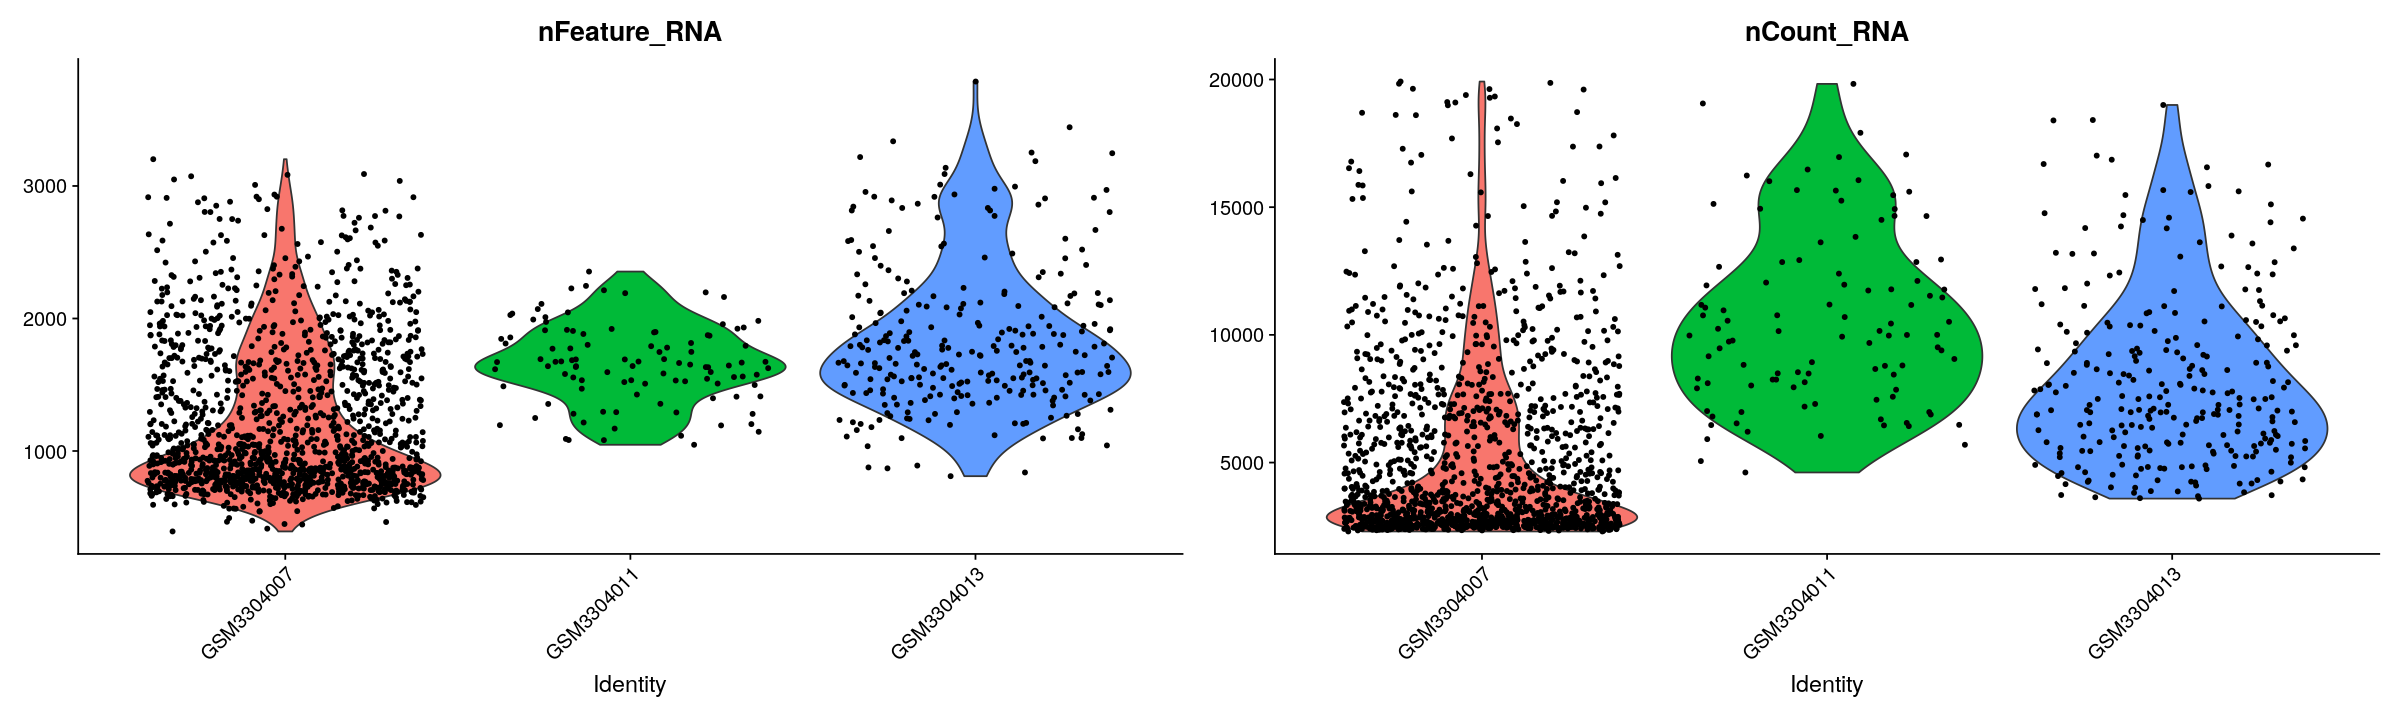

In [17]:
options(repr.plot.width=20, repr.plot.height=6)
VlnPlot(object = seurat_object, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)

###  to find high 10 genes that are most differential expressed

In [18]:
seurat_object <- FindVariableFeatures(seurat_object, nfeatures = 1500)

Warning message in FindVariableFeatures.Assay(object = assay.data, selection.method = selection.method, :
“selection.method set to 'vst' but count slot is empty; will use data slot instead”


When using repel, set xnudge and ynudge to 0 for optimal results



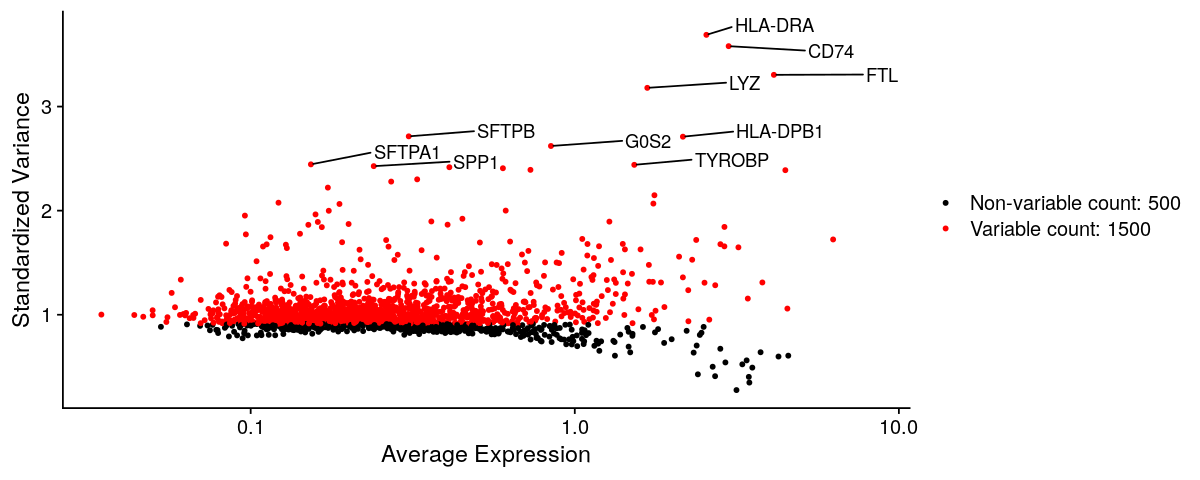

In [19]:
options(repr.plot.width=10, repr.plot.height=4)
plot1 <- VariableFeaturePlot(seurat_object)
LabelPoints(plot=plot1, points=VariableFeatures(seurat_object)[1:10], repel = TRUE)

In [20]:
allGenes <- rownames(seurat_object)
seurat_object <- ScaleData(seurat_object, features = allGenes)

Centering and scaling data matrix



In [21]:
GetAssayData(seurat_object, slot="scale.data")[1:5,1:5]

AAACCTGGTACAGACG-1_1 AAACGGGGTAGCGCTC-1_1 AAACGGGGTCCTCTTG-1_1
APOC1   1.2646056           -0.5788418           -0.5788418          
SFTPB  -0.3377661           -0.3377661           -0.3377661          
SPP1   -0.3155070           -0.3155070           -0.3155070          
SFTPA2 -0.3019852           -0.3019852           -0.3019852          
CCL3    1.3327763           -0.4159488           -0.4159488          
       AAACGGGTCCAAACAC-1_1 AAACGGGTCTTTAGTC-1_1
APOC1  -0.5788418            1.4232882          
SFTPB  -0.3377661           -0.3377661          
SPP1   -0.3155070            1.5984376          
SFTPA2 -0.3019852            1.2585418          
CCL3   -0.4159488           -0.4159488

## PCA

In [22]:
seurat_object <- RunPCA(seurat_object, ndims.print = 1:3, nfeatures.print = 5)

PC_ 1 
Positive:  CST3, TYROBP, FCER1G, GRN, LYZ 
Negative:  MALAT1, BIRC3, CXCR4, IL7R, TUBA4A 
PC_ 2 
Positive:  SRGN, LAPTM5, CREM, CXCR4, GPR183 
Negative:  HOPX, KRT18, KRT8, S100A14, NAPSA 
PC_ 3 
Positive:  MCEMP1, APOC1, RETN, ACP5, GCHFR 
Negative:  NR4A3, G0S2, GPR183, AREG, NFKB1 



In [23]:
print(seurat_object[["pca"]], dims = 1:5, nfeatures = 20)

PC_ 1 
Positive:  CST3, TYROBP, FCER1G, GRN, LYZ, PSAP, CTSB, FTL, GPX1, AIF1 
	   CD68, HLA-DRB1, FCGRT, NPC2, HLA-DRA, HLA-DPA1, S100A11, MS4A7, FCGR2A, HLA-DMA 
Negative:  MALAT1, BIRC3, CXCR4, IL7R, TUBA4A, ISG20, CD69, FAM177A1, YPEL5, CYTIP 
	   SC5D, CD48, ARID5B, JUNB, IL32, HSP90AA1, BTG2, ODF2L, DDIT4, LINC-PINT 
PC_ 2 
Positive:  SRGN, LAPTM5, CREM, CXCR4, GPR183, LST1, TYROBP, SAMSN1, HLA-DQA1, AIF1 
	   HLA-DPB1, C1orf162, MS4A6A, FCER1G, RGS1, HLA-DPA1, KYNU, BCL2A1, ITGB2, OLR1 
Negative:  HOPX, KRT18, KRT8, S100A14, NAPSA, WFDC2, MGST1, SLC34A2, EMP2, SFTPB 
	   SFTA2, C8orf4, KRT19, ELF3, CXCL17, S100A13, SLPI, GPRC5A, TM4SF1, MUC1 
PC_ 3 
Positive:  MCEMP1, APOC1, RETN, ACP5, GCHFR, LINC01272, MS4A4A, CFD, RP11-1143G9.4, LRPAP1 
	   CTSD, FBP1, FCGR3A, PLD3, CD52, S100A9, CTSL, HDDC2, TGM2, HNMT 
Negative:  NR4A3, G0S2, GPR183, AREG, NFKB1, FNIP2, RGS2, CD83, NINJ1, NAMPT 
	   MALAT1, C15orf48, INSIG1, PTPRE, CREM, SERPINB9, SOD2, CHMP1B, PAK1, IER3 
PC_ 4 
Positive: 

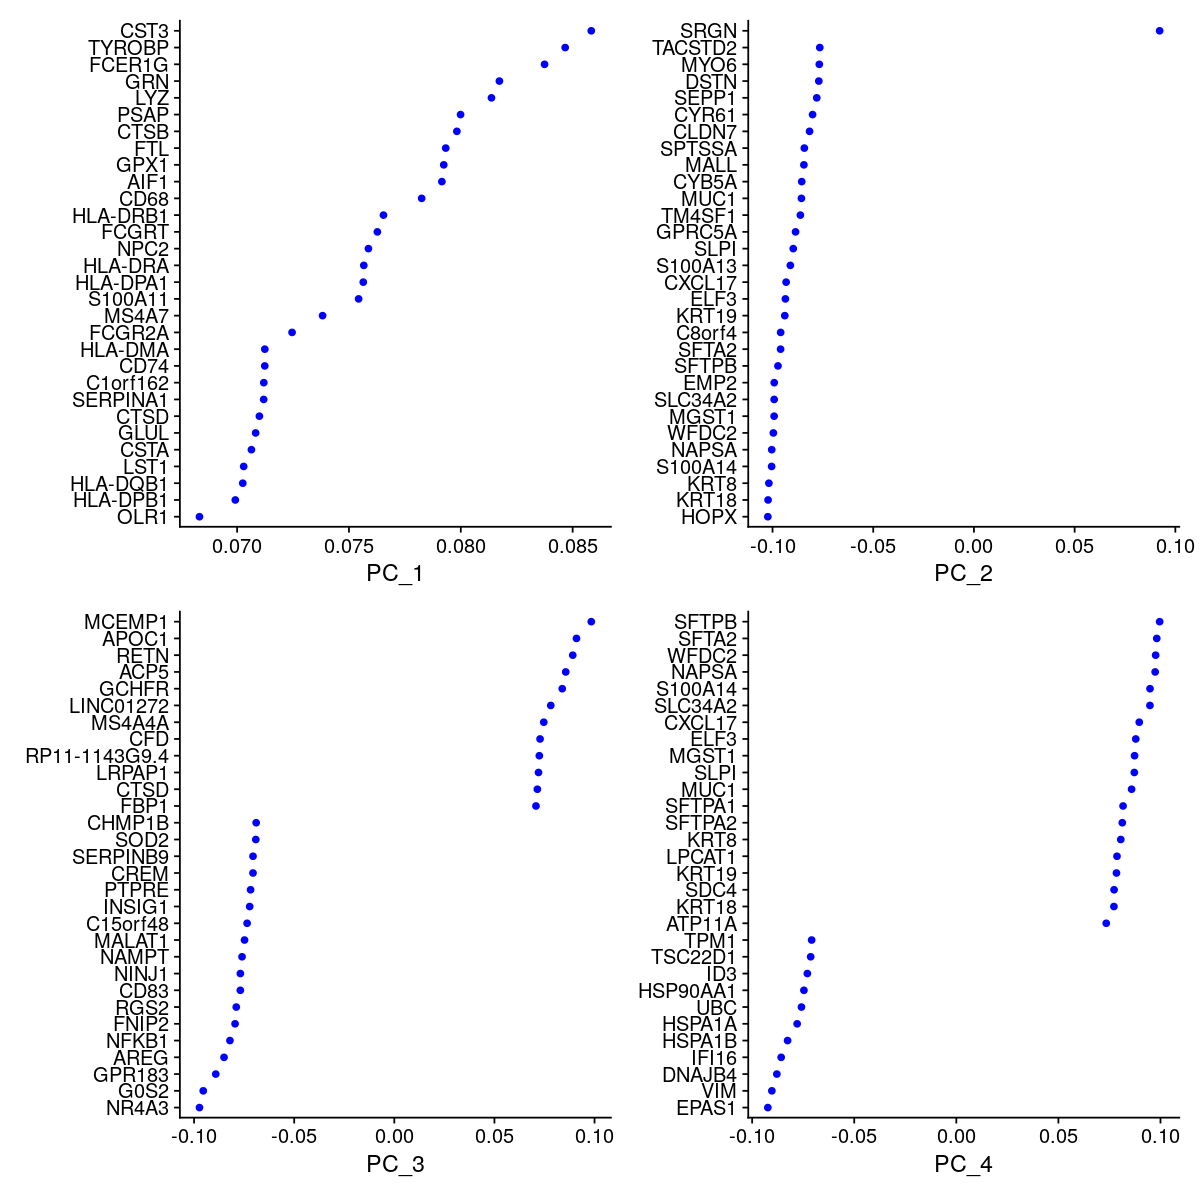

In [24]:
options(repr.plot.width=10, repr.plot.height=10)
VizDimLoadings(seurat_object, dims = 1:4, reduction = "pca")

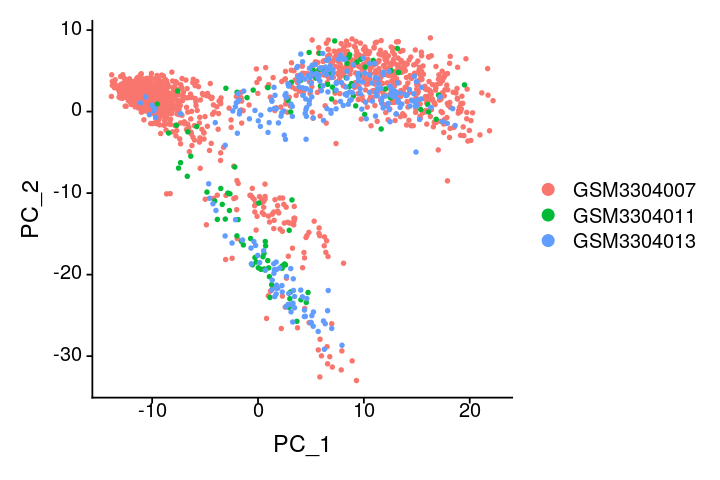

In [25]:
options(repr.plot.width=6, repr.plot.height=4)
DimPlot(seurat_object, reduction = "pca")

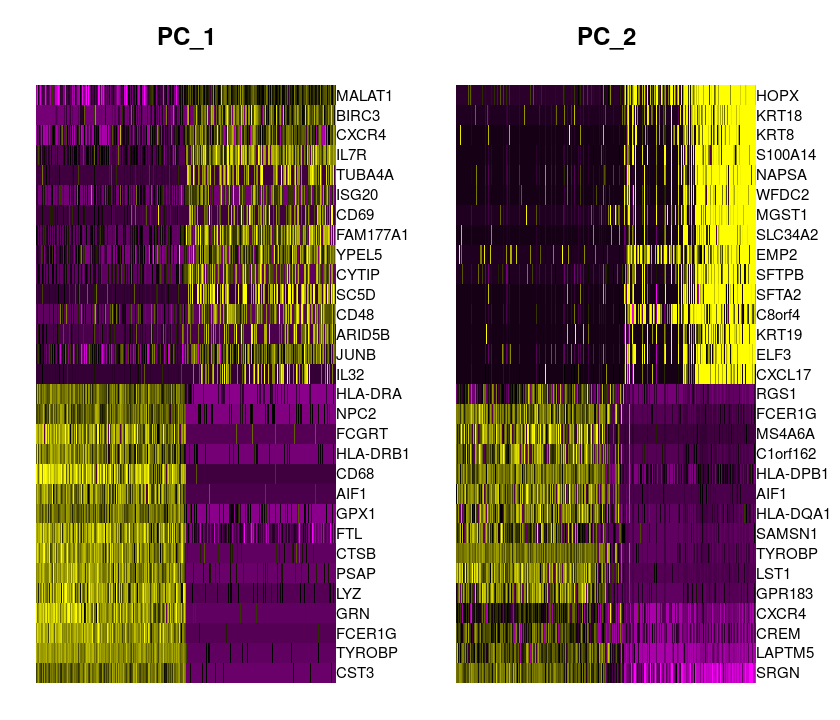

In [26]:
options(repr.plot.width=7, repr.plot.height=6)
DimHeatmap(seurat_object, dims = 1:2, cells = 500, balanced = TRUE)

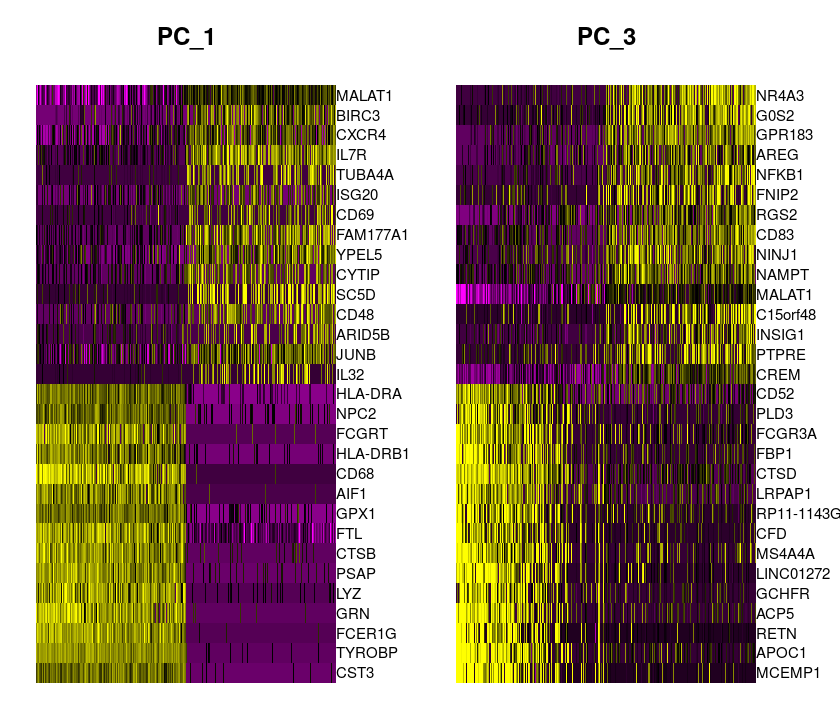

In [27]:
options(repr.plot.width=7, repr.plot.height=6)
DimHeatmap(seurat_object, dims = c(1,3), cells = 500, balanced = TRUE)

## clustering cells

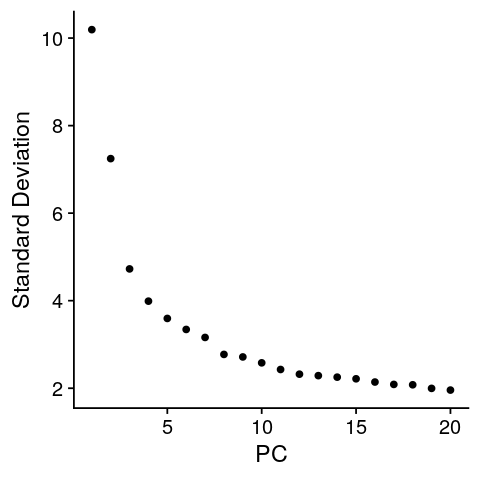

In [28]:
options(repr.plot.width=4, repr.plot.height=4)
ElbowPlot(seurat_object, ndims=20)

Warning message:
“Removed 21300 rows containing missing values (`geom_point()`).”


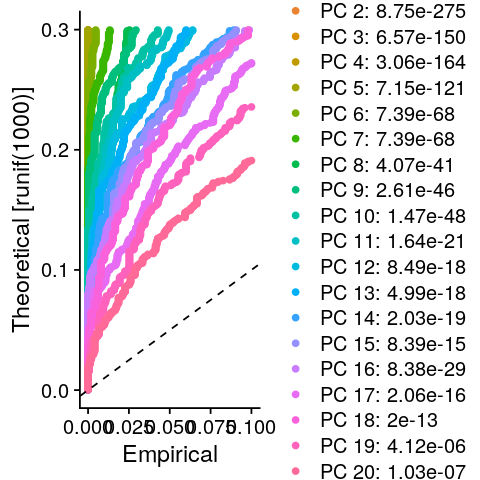

In [29]:
seurat_object <- JackStraw(seurat_object, num.replicate = 100)
seurat_object <- ScoreJackStraw(seurat_object, dims = 1:20)
JackStrawPlot(seurat_object, dims = 1:20)

### PCA determined 20 PCs with an estimated p value < 0.01. 
From ElbowPlot, the elbow would fall around PC 10 or 15, which means that the first 10 or 15 PCs capture the majority of signal.
Based on the PCs number in the corresponding paper, we will use first 15 PCs for clustering cells
And also the same resolution 0.6

In [30]:
seurat_object <- FindNeighbors(seurat_object, dims = 1:15)
seurat_object <- FindClusters(seurat_object, resolution = c(0.6, 1.0, 2.0))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1796
Number of edges: 63727

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8622
Number of communities: 10
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1796
Number of edges: 63727

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8157
Number of communities: 12
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1796
Number of edges: 63727

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7261
Number of communities: 16
Elapsed time: 0 seconds


In [31]:
head(seurat_object[[]])

orig.ident nCount_RNA nFeature_RNA percent.mt AllData
AAACCTGGTACAGACG-1_1 GSM3304007  4338      1224         2.512679   AllData
AAACGGGGTAGCGCTC-1_1 GSM3304007 11724      2456         2.021494   AllData
AAACGGGGTCCTCTTG-1_1 GSM3304007  3353       726         2.117507   AllData
AAACGGGTCCAAACAC-1_1 GSM3304007  2811       986         2.312344   AllData
AAACGGGTCTTTAGTC-1_1 GSM3304007  6095      1590         3.002461   AllData
AAAGATGCATCTACGA-1_1 GSM3304007  7683      2049         2.824418   AllData
                     integrated_snn_res.0.6 integrated_snn_res.1
AAACCTGGTACAGACG-1_1 1                      4                   
AAACGGGGTAGCGCTC-1_1 8                      10                  
AAACGGGGTCCTCTTG-1_1 0                      0                   
AAACGGGTCCAAACAC-1_1 3                      2                   
AAACGGGTCTTTAGTC-1_1 1                      4                   
AAAGATGCATCTACGA-1_1 9                      11                  
                     integrated_snn_res.2 seurat_clusters
AAACCTGGTACAGACG-1_1 2                    2              
AAACGGGGTAGCGCTC-1_1 14                   14             
AAACGGGGTCCTCTTG-1_1 7                    7              
AAACGGGTCCAAACAC-1_1 1                    1              
AAACGGGTCTTTAGTC-1_1 2                    2              
AAAGATGCATCTACGA-1_1 15                   15

In [32]:
# How many clusters are there in each resolution?
for (x in c('integrated_snn_res.0.6', 'integrated_snn_res.1', 'integrated_snn_res.2'))
{
    message(x, ': ', length(unique(unlist(seurat_object[[x]]))), ' custers')
}    

integrated_snn_res.0.6: 10 custers

integrated_snn_res.1: 12 custers

integrated_snn_res.2: 16 custers



In [33]:
table(Idents(seurat_object))


  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 
170 161 150 145 141 134 128 124 124 112 109  88  68  66  48  28 

##  2D projections

In [34]:
# tSNE
seurat_object <- RunTSNE(seurat_object, dims = 1:15)
# UMAP
seurat_object <- RunUMAP(seurat_object, dims = 1:15)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:21:20 UMAP embedding parameters a = 0.9922 b = 1.112

14:21:20 Read 1796 rows and found 15 numeric columns

14:21:20 Using Annoy for neighbor search, n_neighbors = 30

14:21:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

14:21:20 Writing NN index file to temp file /tmp/RtmptQnaNb/file4b4b7fcaee15

14:21:20 Searching Annoy index using 1 thread, search_k = 3000

14:21:21 Annoy recall = 100%

14:21:21 Commencing smooth kNN distance calibration using 1 thread

14:21:22 Initializing fr

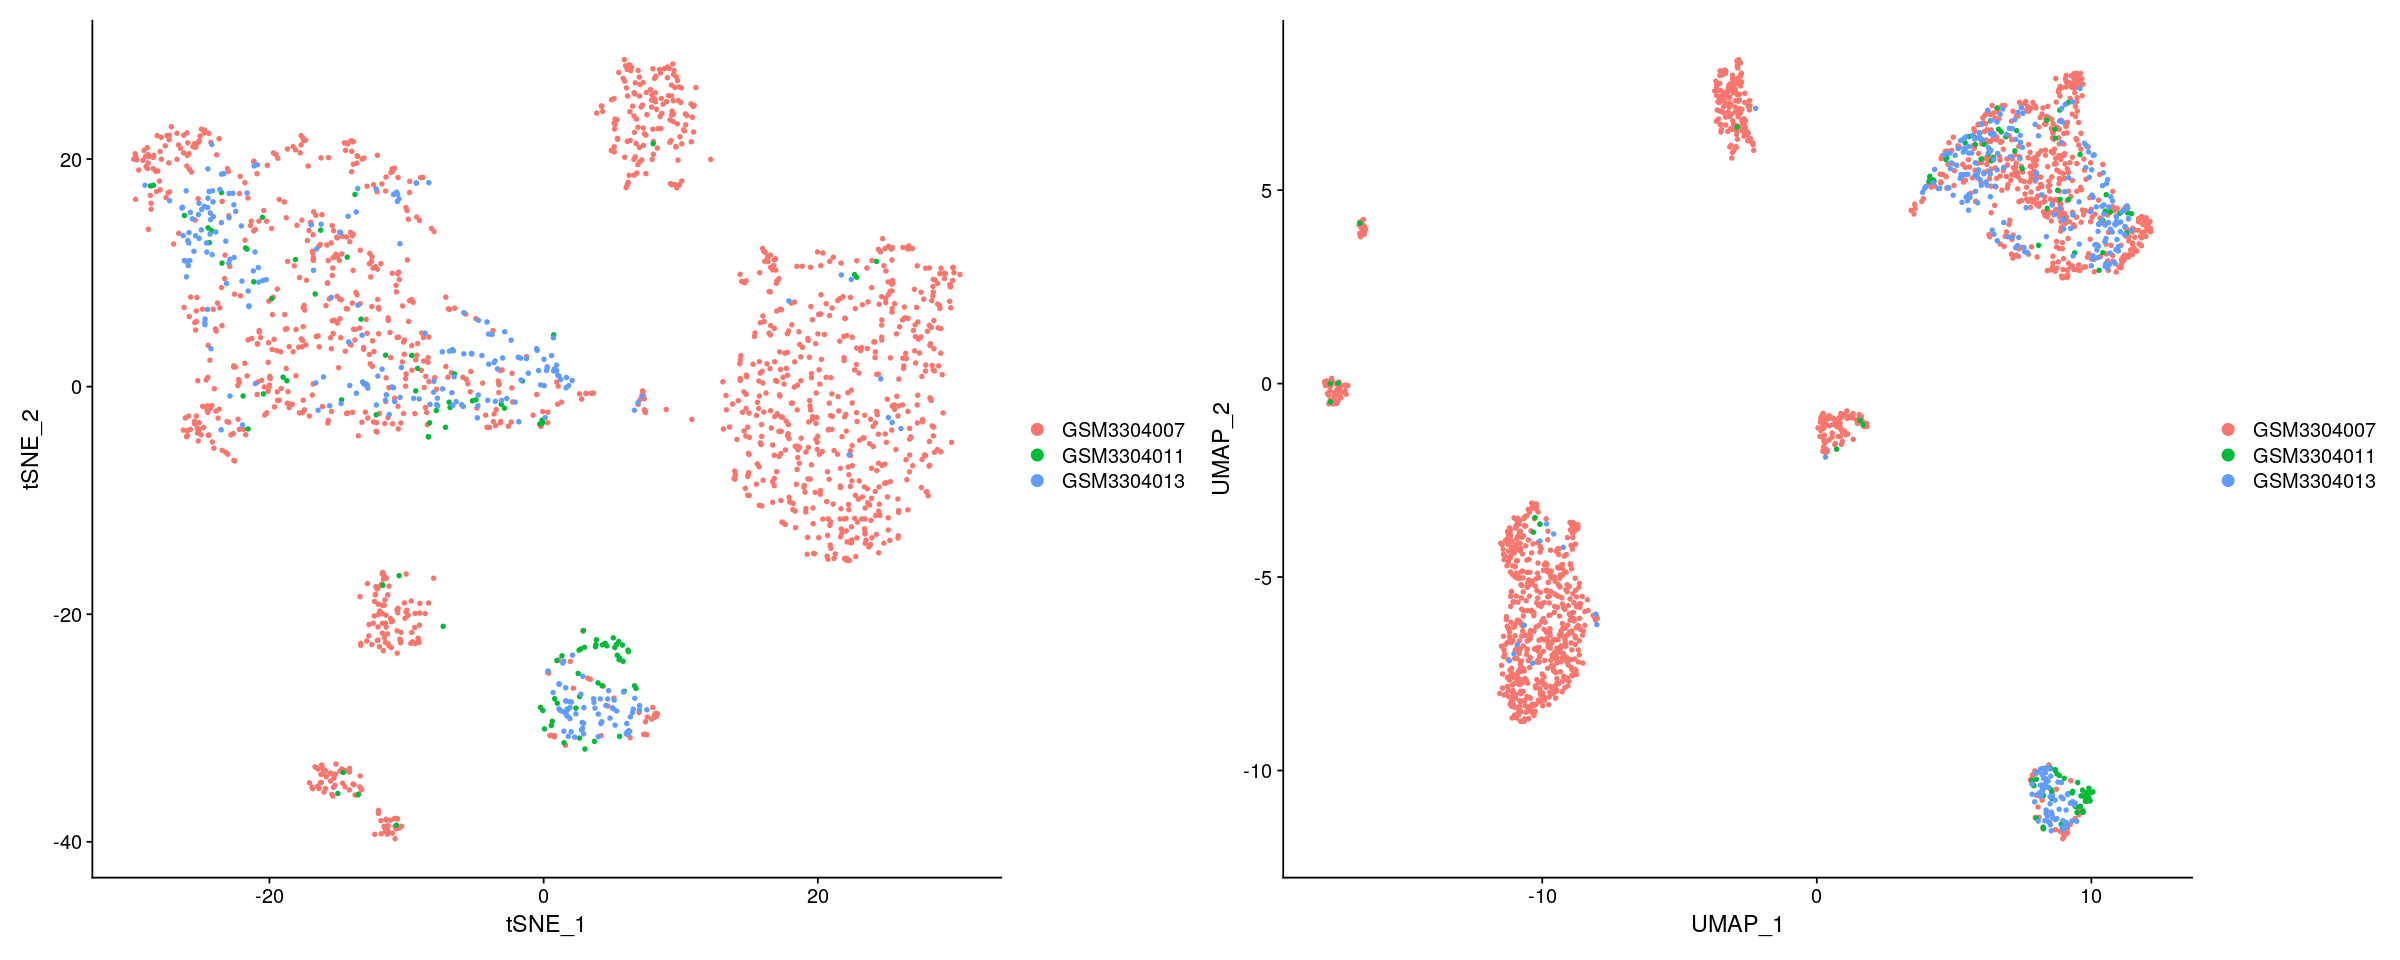

In [35]:
options(repr.plot.width=20, repr.plot.height=8)
plot1 <- DimPlot(seurat_object, reduction = "tsne", group.by = "orig.ident")
plot2 <- DimPlot(seurat_object, reduction = "umap",  group.by = "orig.ident")
plot1 + plot2

### Based on TSNE and UMAP plots, we can find some groups

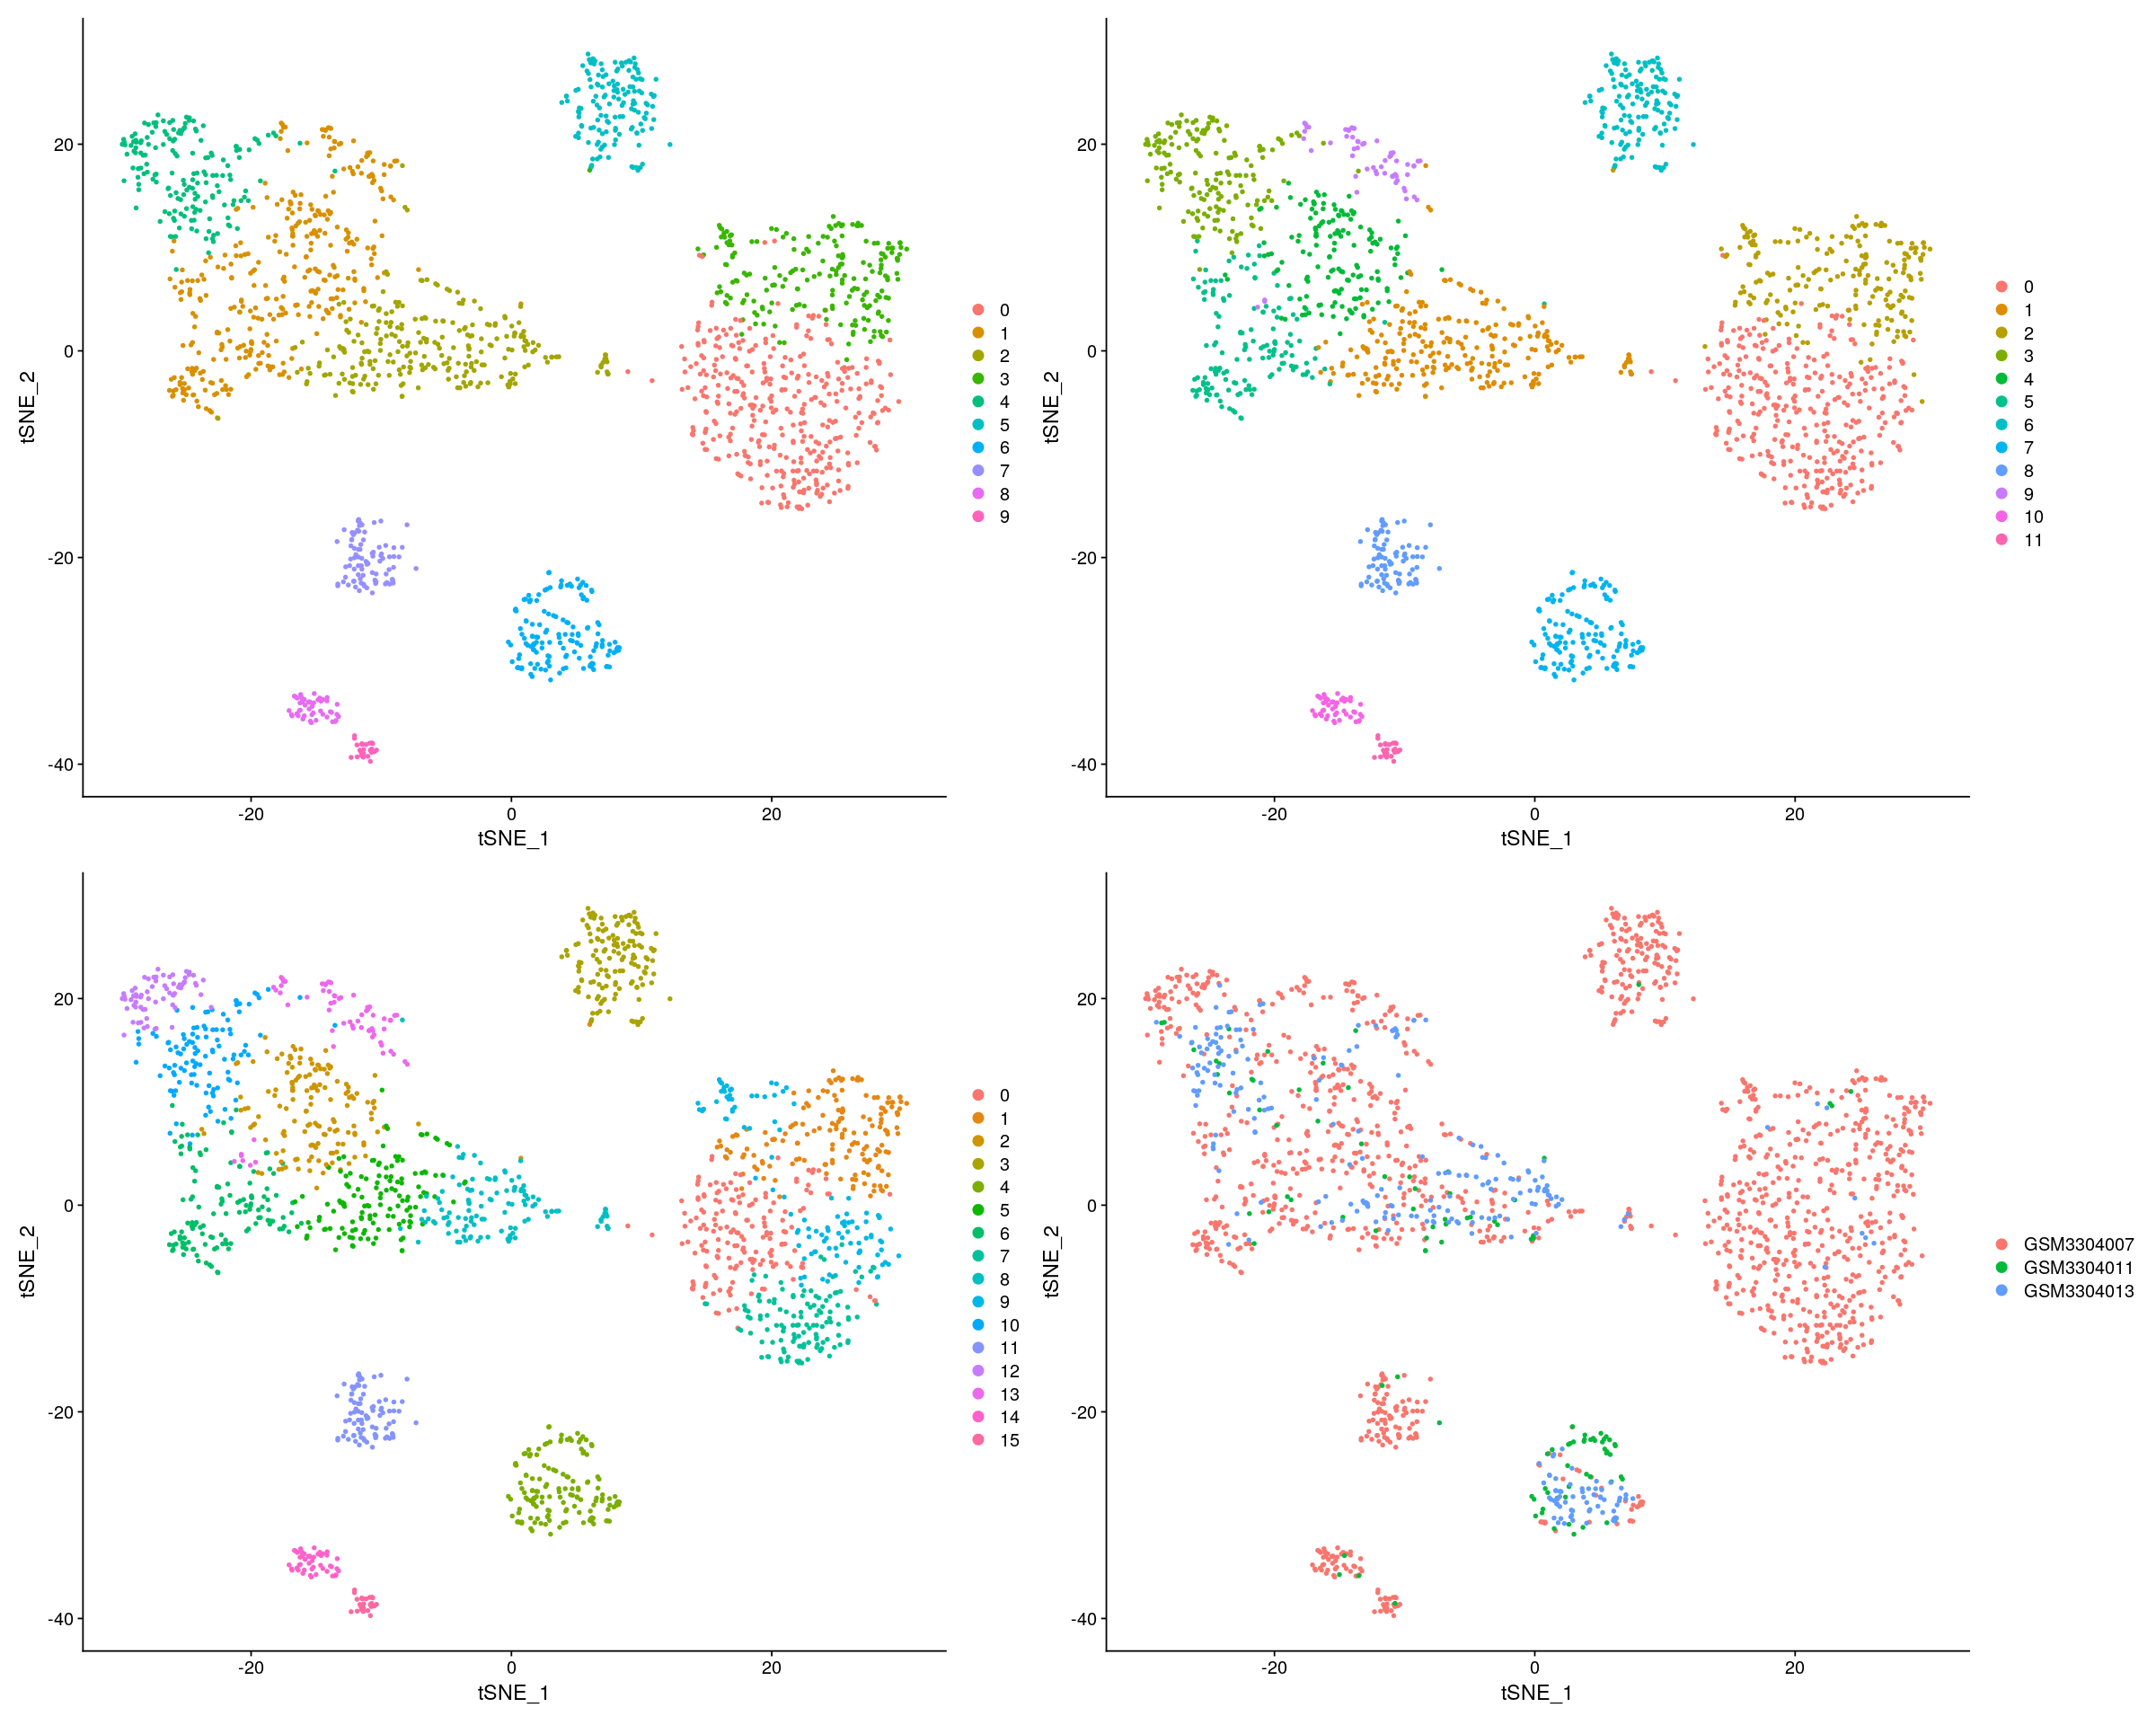

In [36]:
options(repr.plot.width=20, repr.plot.height=16)
plot1 <- DimPlot(seurat_object, reduction = "tsne", group.by = 'integrated_snn_res.0.6')
plot2 <- DimPlot(seurat_object, reduction = "tsne", group.by = 'integrated_snn_res.1')
plot3 <- DimPlot(seurat_object, reduction = "tsne", group.by = 'integrated_snn_res.2')
plot4 <- DimPlot(seurat_object, reduction = "tsne", group.by = "orig.ident")
plot1 + plot2 + plot3 + plot4

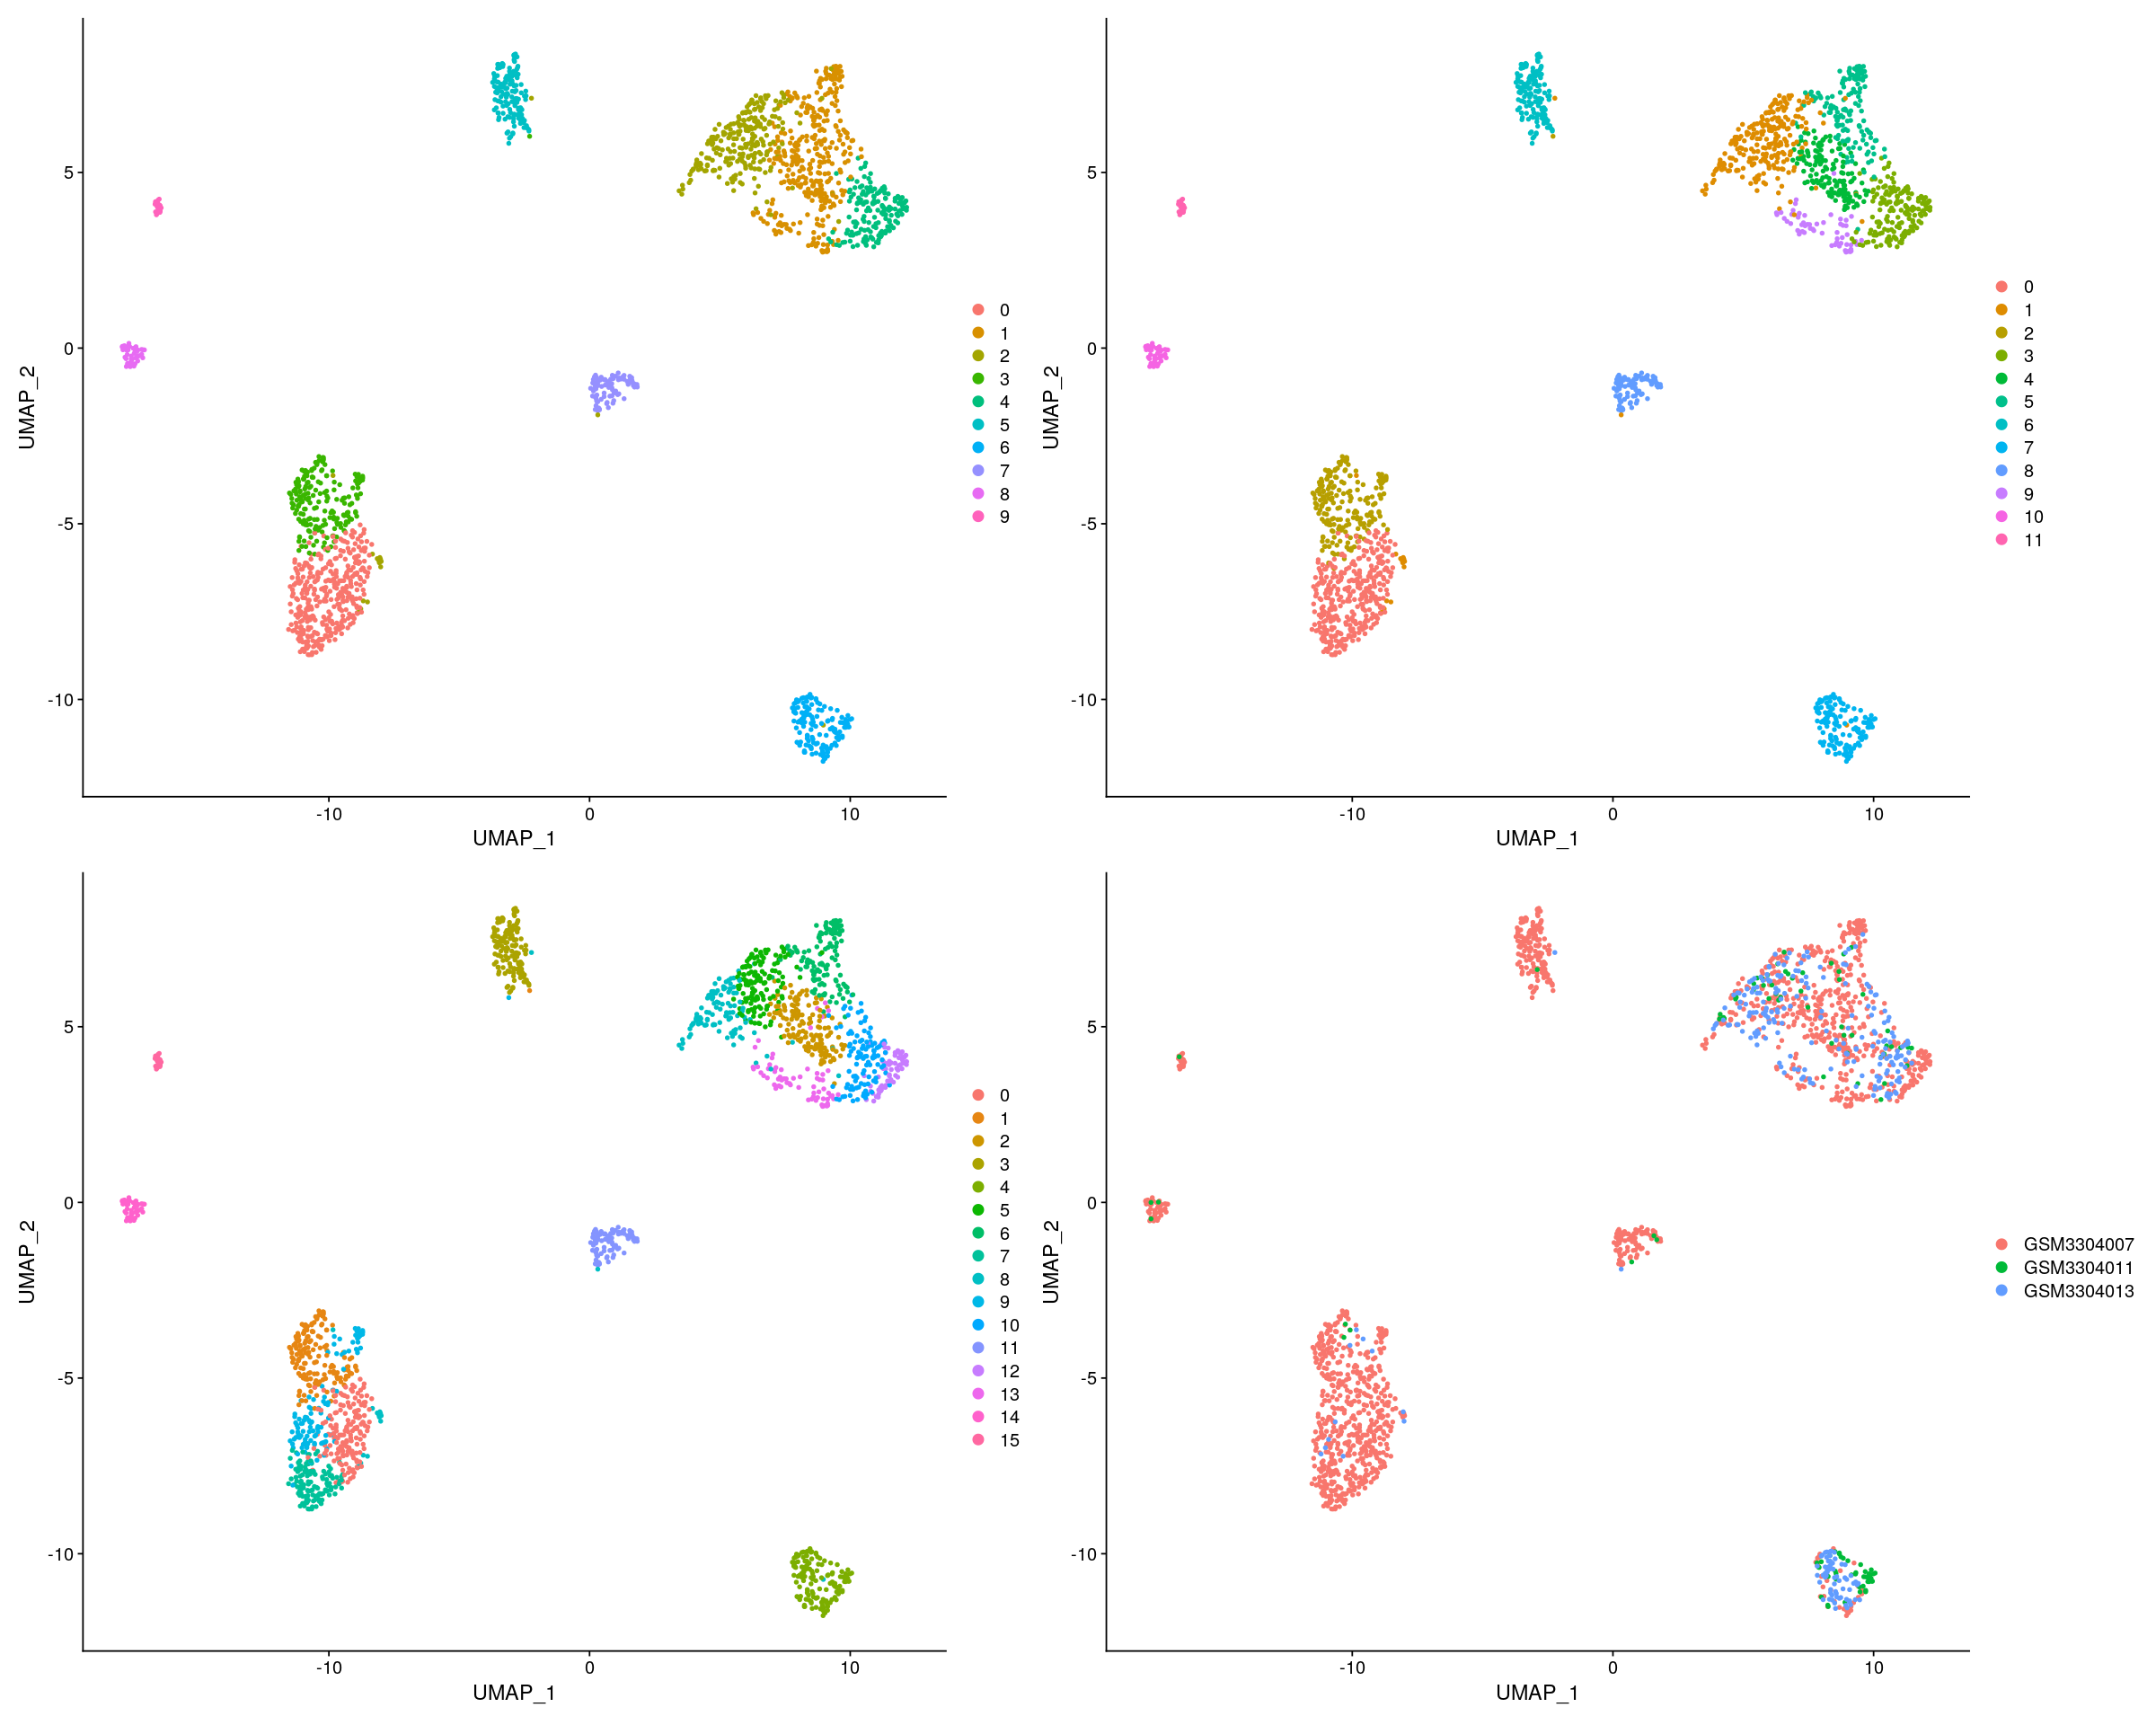

In [37]:
options(repr.plot.width=20, repr.plot.height=16)
plot1 <- DimPlot(seurat_object, reduction = "umap", group.by = 'integrated_snn_res.0.6')
plot2 <- DimPlot(seurat_object, reduction = "umap", group.by = 'integrated_snn_res.1')
plot3 <- DimPlot(seurat_object, reduction = "umap", group.by = 'integrated_snn_res.2')
plot4 <- DimPlot(seurat_object, reduction = "umap", group.by = "orig.ident")
plot1 + plot2 + plot3 + plot4

### According to t-SNE algorithm, 1796 LUAD cells were successfully aggregated into 10 clusters
(the same as cluster number in paper)

In [38]:
Idents(seurat_object) <- 'integrated_snn_res.0.6'
table(Idents(seurat_object))


  0   1   2   3   4   5   6   7   8   9 
366 353 257 200 169 146 141  88  48  28 

In [39]:
table(Idents(seurat_object), seurat_object$orig.ident)

   
    GSM3304007 GSM3304011 GSM3304013
  0        361          0          5
  1        296         15         42
  2        133         23        101
  3        194          3          3
  4        102         11         56
  5        145          1          0
  6         32         44         65
  7         85          3          0
  8         45          3          0
  9         27          1          0

In [40]:
cntByPatient = table(Idents(seurat_object), seurat_object$orig.ident)
cntByPatient = t(round(cntByPatient/rowSums(cntByPatient), 2))
cbind(sort(apply(cntByPatient, 2, max)))

[,1]
6 0.46
2 0.52
4 0.60
1 0.84
8 0.94
9 0.96
3 0.97
7 0.97
0 0.99
5 0.99

### Differentially expressed genes / Markers


In [41]:
Idents(seurat_object) <- 'integrated_snn_res.0.6'
table(Idents(seurat_object))


  0   1   2   3   4   5   6   7   8   9 
366 353 257 200 169 146 141  88  48  28 

In [42]:
DEGs <- FindAllMarkers(seurat_object, only.pos=TRUE, min.pct=0.25)

# Save the markers for later
saveRDS(DEGs, file = "DEG.rds")

# To save as text:
write.table(DEGs, file = "DEGs.txt", sep = "\t", quote = F, col.names = F)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9



In [43]:
DEGs_top5 <- DEGs %>% group_by(cluster) %>% top_n(5, avg_logFC)
DEGs_top5[1:20,]

p_val         avg_logFC pct.1 pct.2 p_val_adj     cluster gene    
1  8.472812e-124 1.6036101 0.932 0.547 1.694562e-120 0       IL7R    
2   5.178667e-47 0.8615294 0.776 0.601  1.035733e-43 0       FAM177A1
3   4.268190e-43 0.8249040 0.839 0.690  8.536379e-40 0       BIRC3   
4   3.069112e-39 0.9225590 0.519 0.283  6.138224e-36 0       SC5D    
5   2.060661e-21 0.8510831 0.505 0.380  4.121322e-18 0       TUBA4A  
6   5.427544e-77 1.8918630 0.686 0.267  1.085509e-73 1       EREG    
7   1.731164e-57 1.7615955 0.708 0.325  3.462327e-54 1       G0S2    
8   1.467062e-44 1.7425963 0.618 0.267  2.934123e-41 1       CXCL8   
9   1.781253e-30 1.5960899 0.504 0.250  3.562506e-27 1       CXCL3   
10  1.286114e-23 1.7485630 0.422 0.184  2.572227e-20 1       IL1B    
11  2.928939e-69 1.0297037 0.883 0.356  5.857878e-66 2       NR4A3   
12  1.036254e-65 1.1680637 0.961 0.699  2.072508e-62 2       HLA-DPB1
13  6.115191e-57 0.9311806 0.946 0.559  1.223038e-53 2       CD83    
14  2.286462e-47 1.1294031 0.903 0.586  4.572923e-44 2       GPR183  
15  4.730863e-34 0.8550749 0.743 0.343  9.461725e-31 2       G0S2    
16  3.079102e-42 1.4683470 0.765 0.447  6.158205e-39 3       DUSP4   
17  3.226427e-36 1.0494654 0.850 0.694  6.452855e-33 3       HMGB2   
18  4.662599e-32 1.1293172 0.670 0.413  9.325198e-29 3       NR3C1   
19  2.376063e-30 1.1243217 0.655 0.387  4.752125e-27 3       IL32    
20  1.991872e-27 1.1296401 0.755 0.539  3.983744e-24 3       PMAIP1

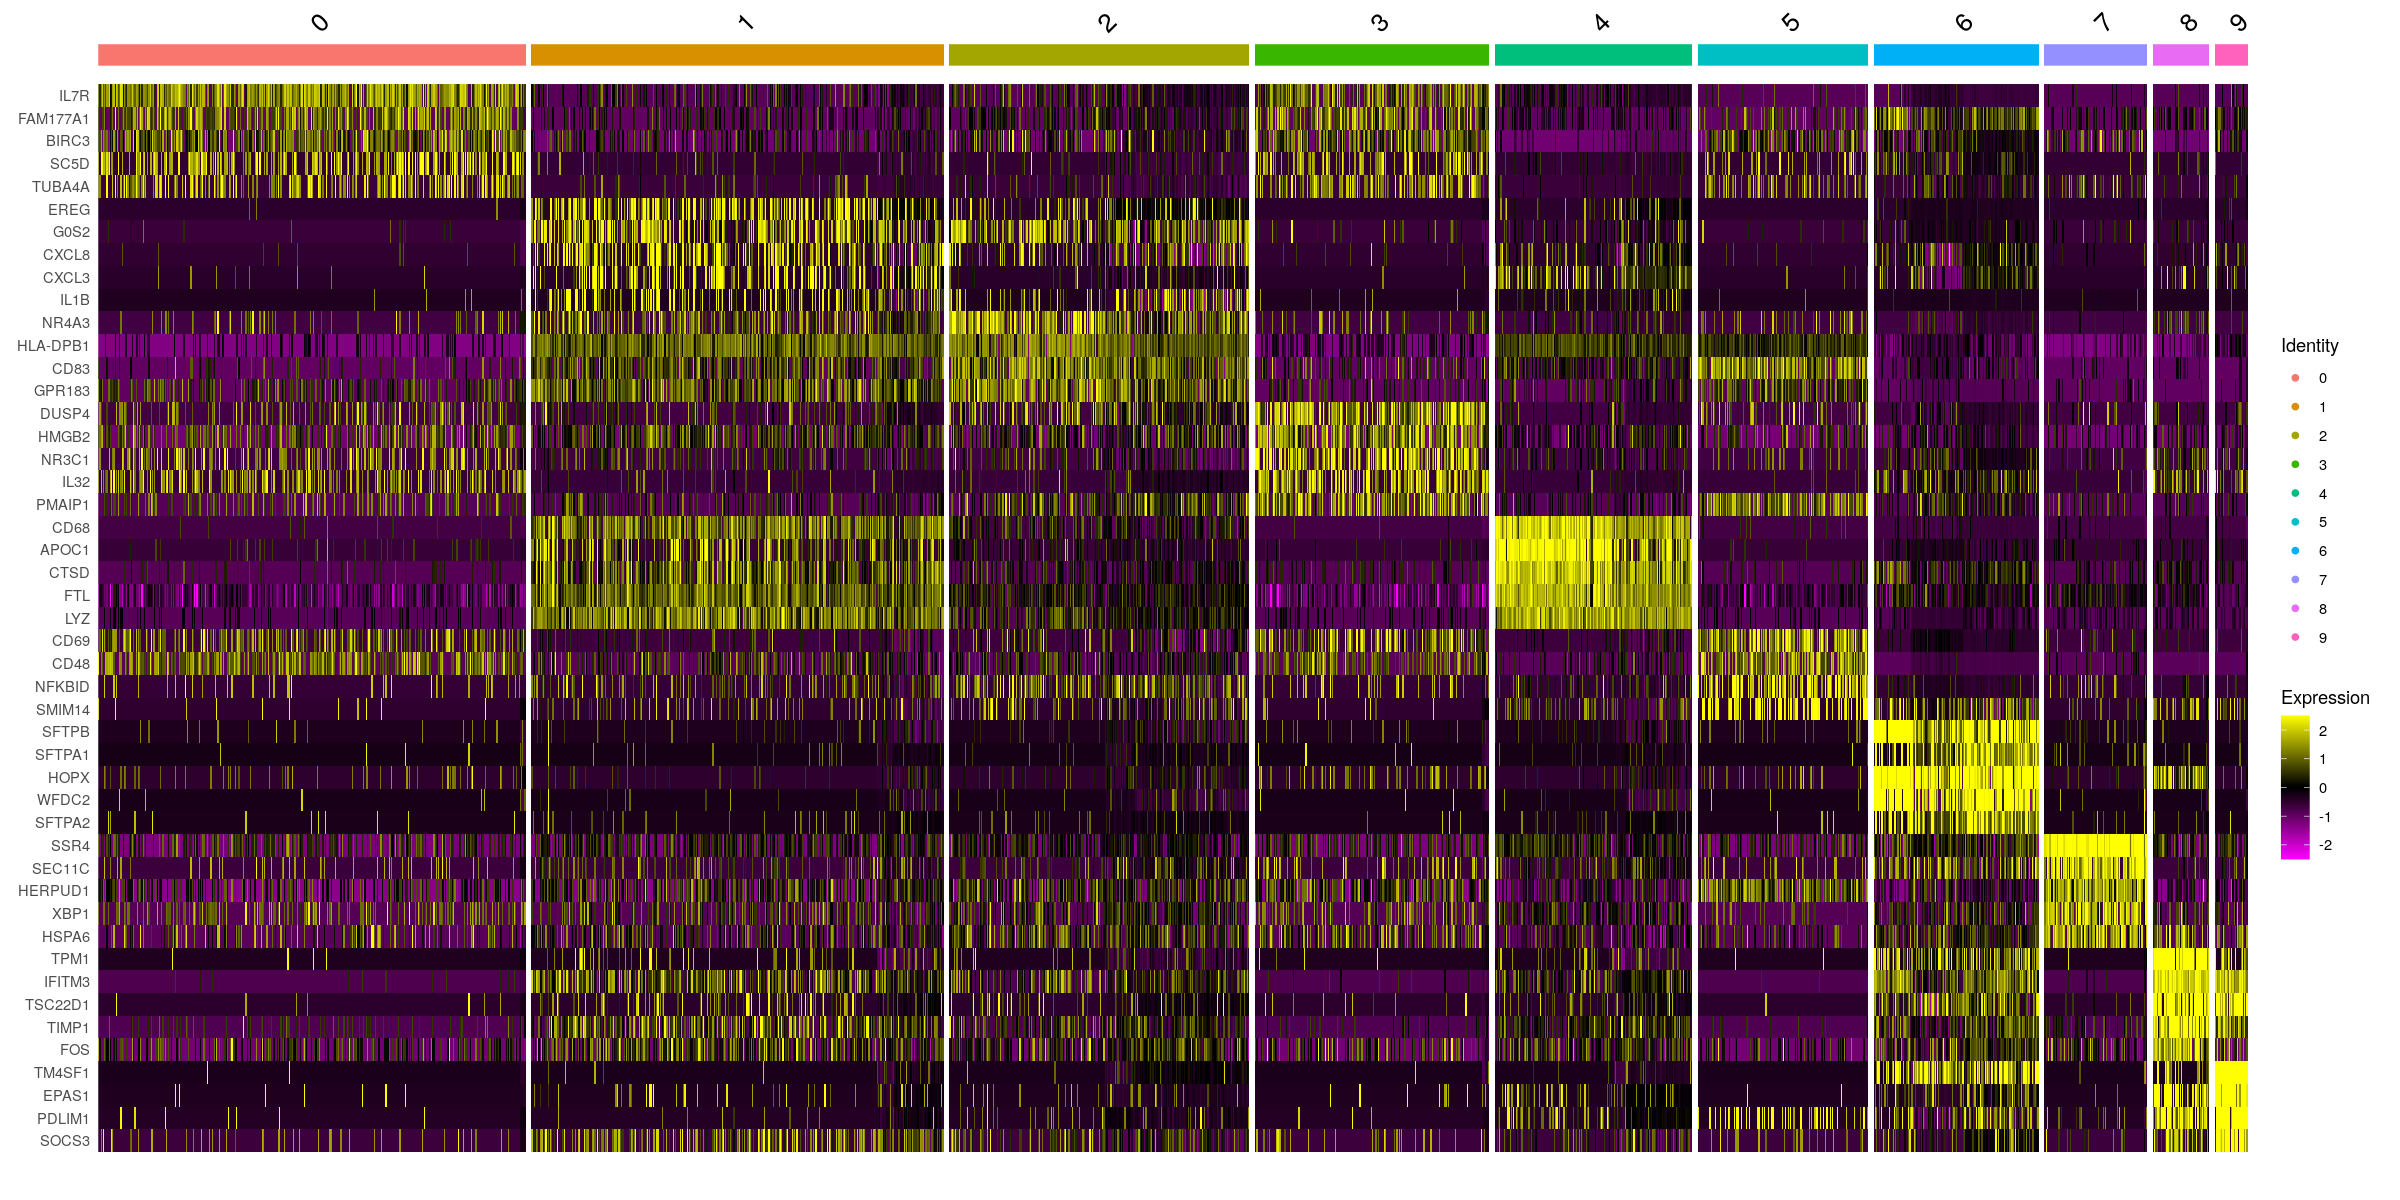

In [44]:
options(repr.plot.width=20, repr.plot.height=10)
DoHeatmap(seurat_object, features = DEGs_top5$gene)

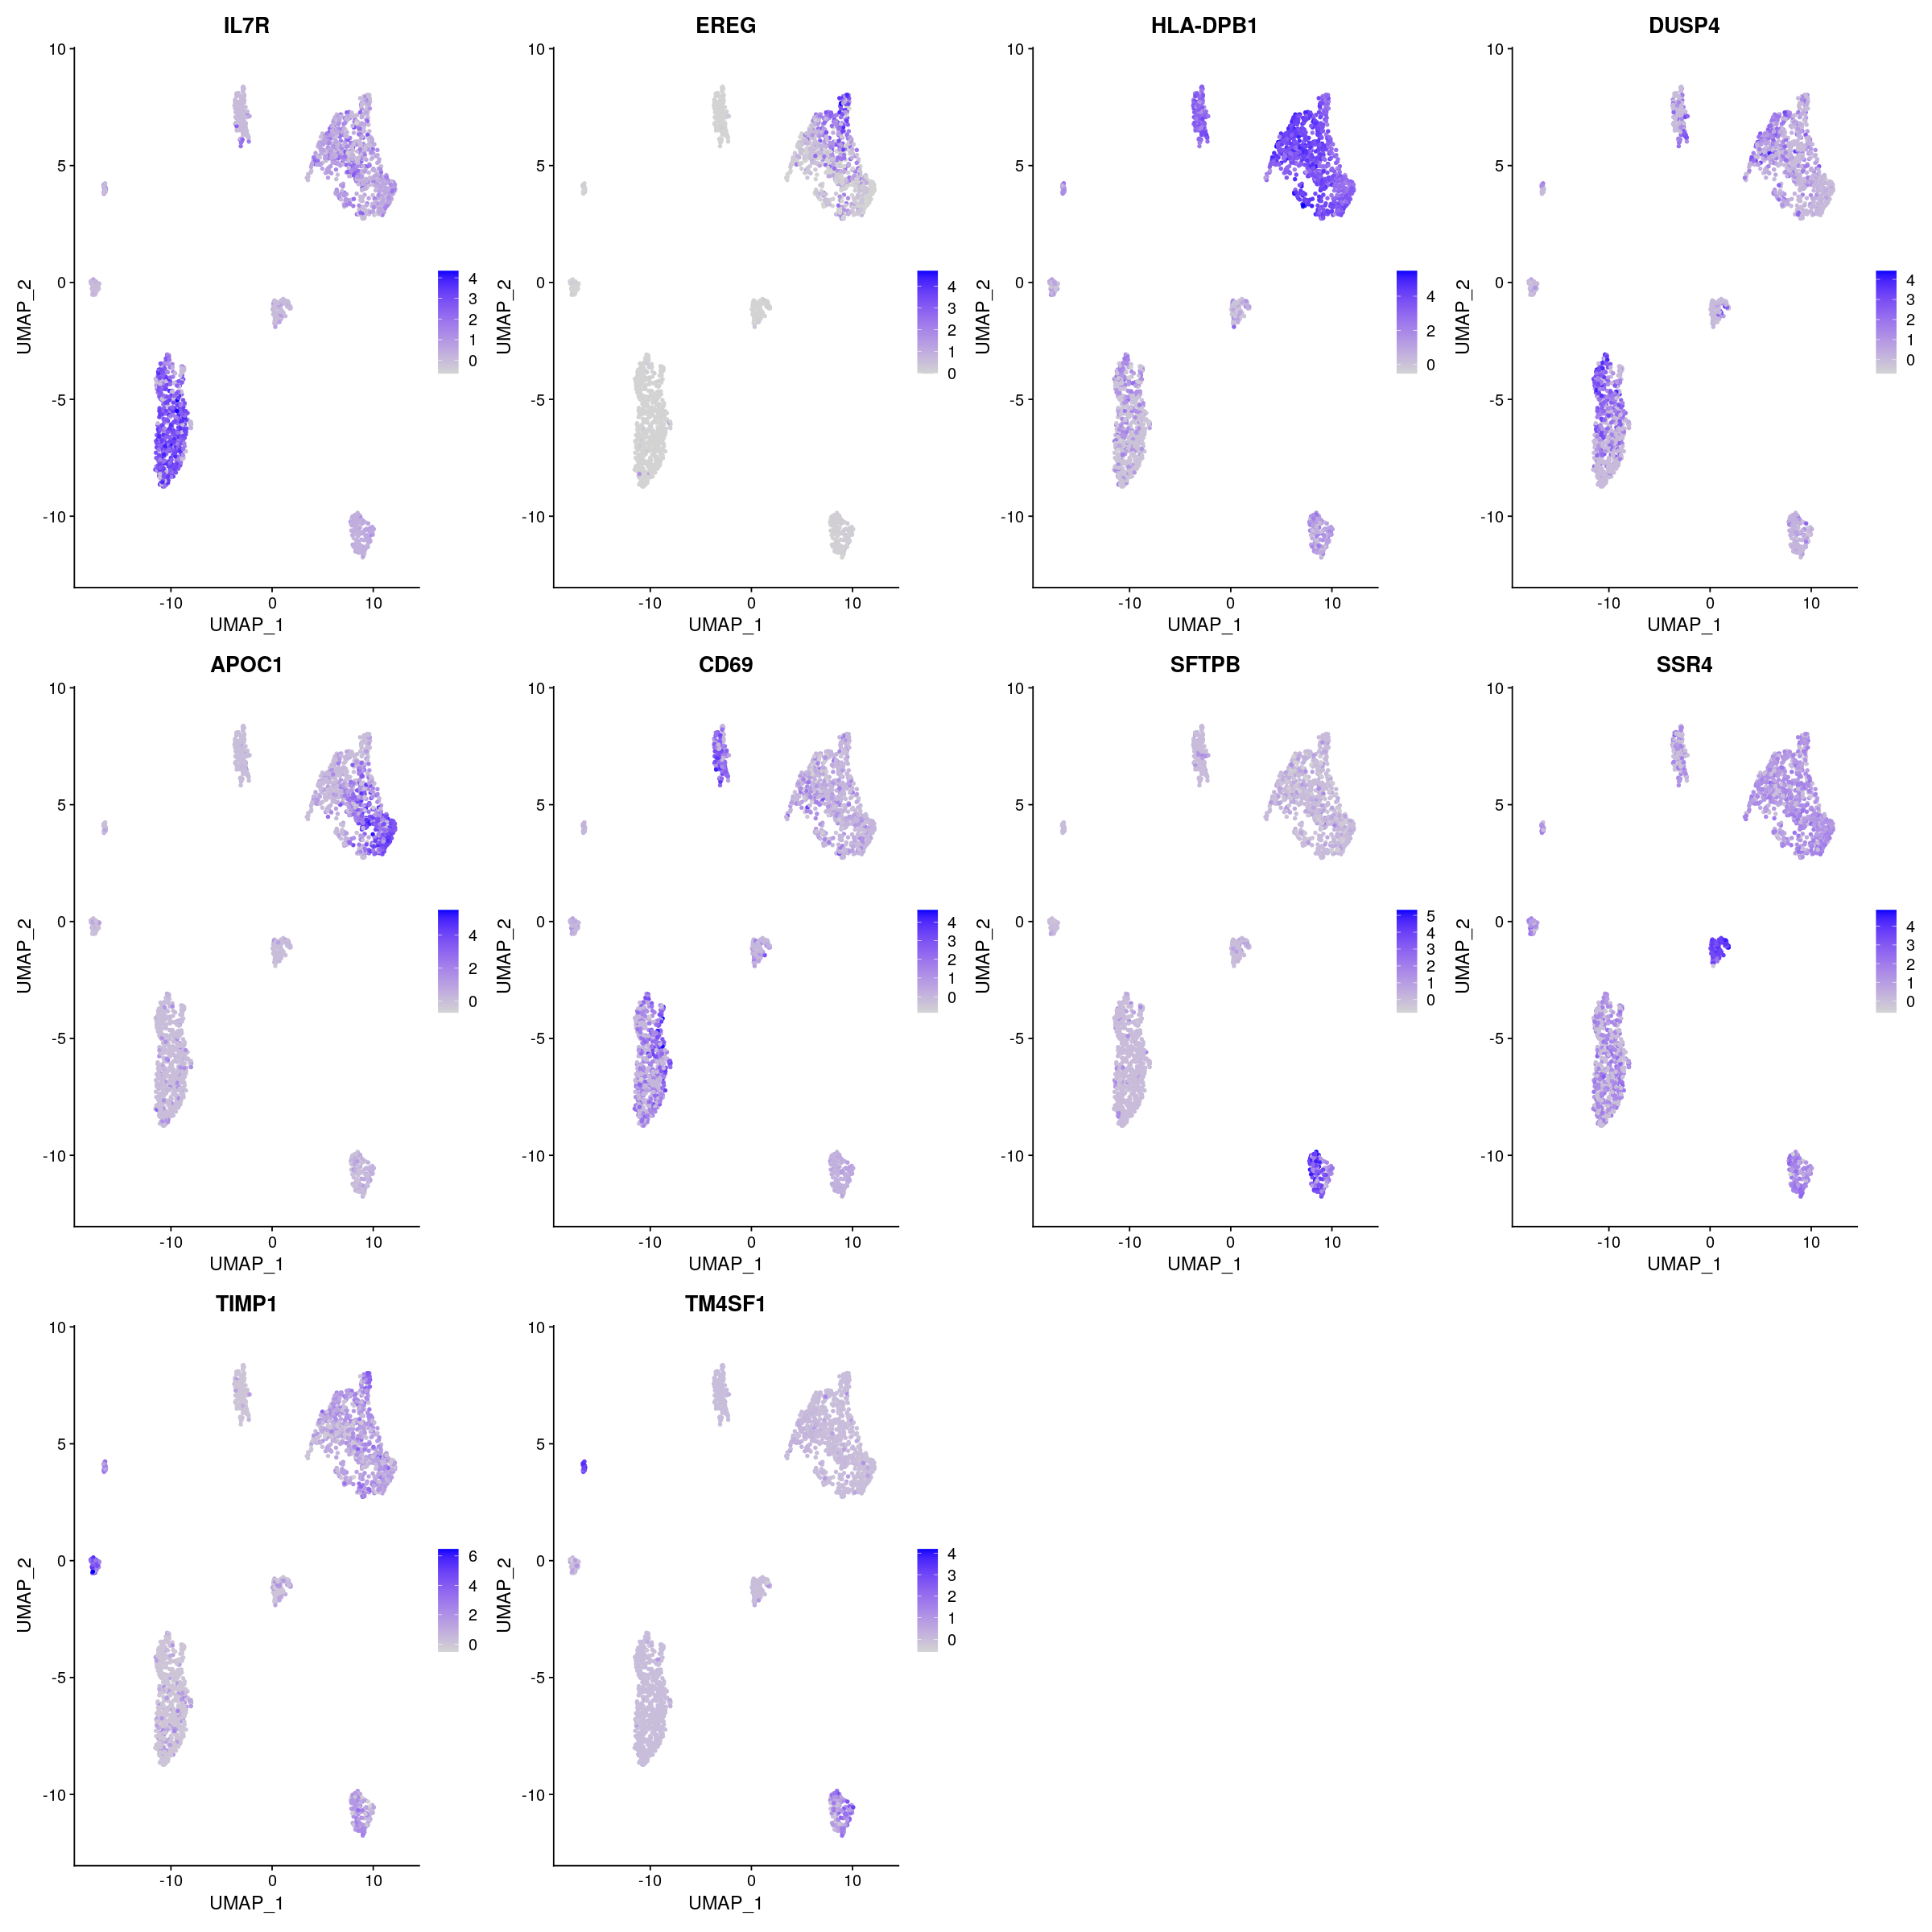

In [45]:
options(repr.plot.width=20, repr.plot.height=20)
top1 <- DEGs %>% group_by(cluster) %>% top_n(n = 1, wt = avg_logFC)
FeaturePlot(seurat_object, features = top1$gene)

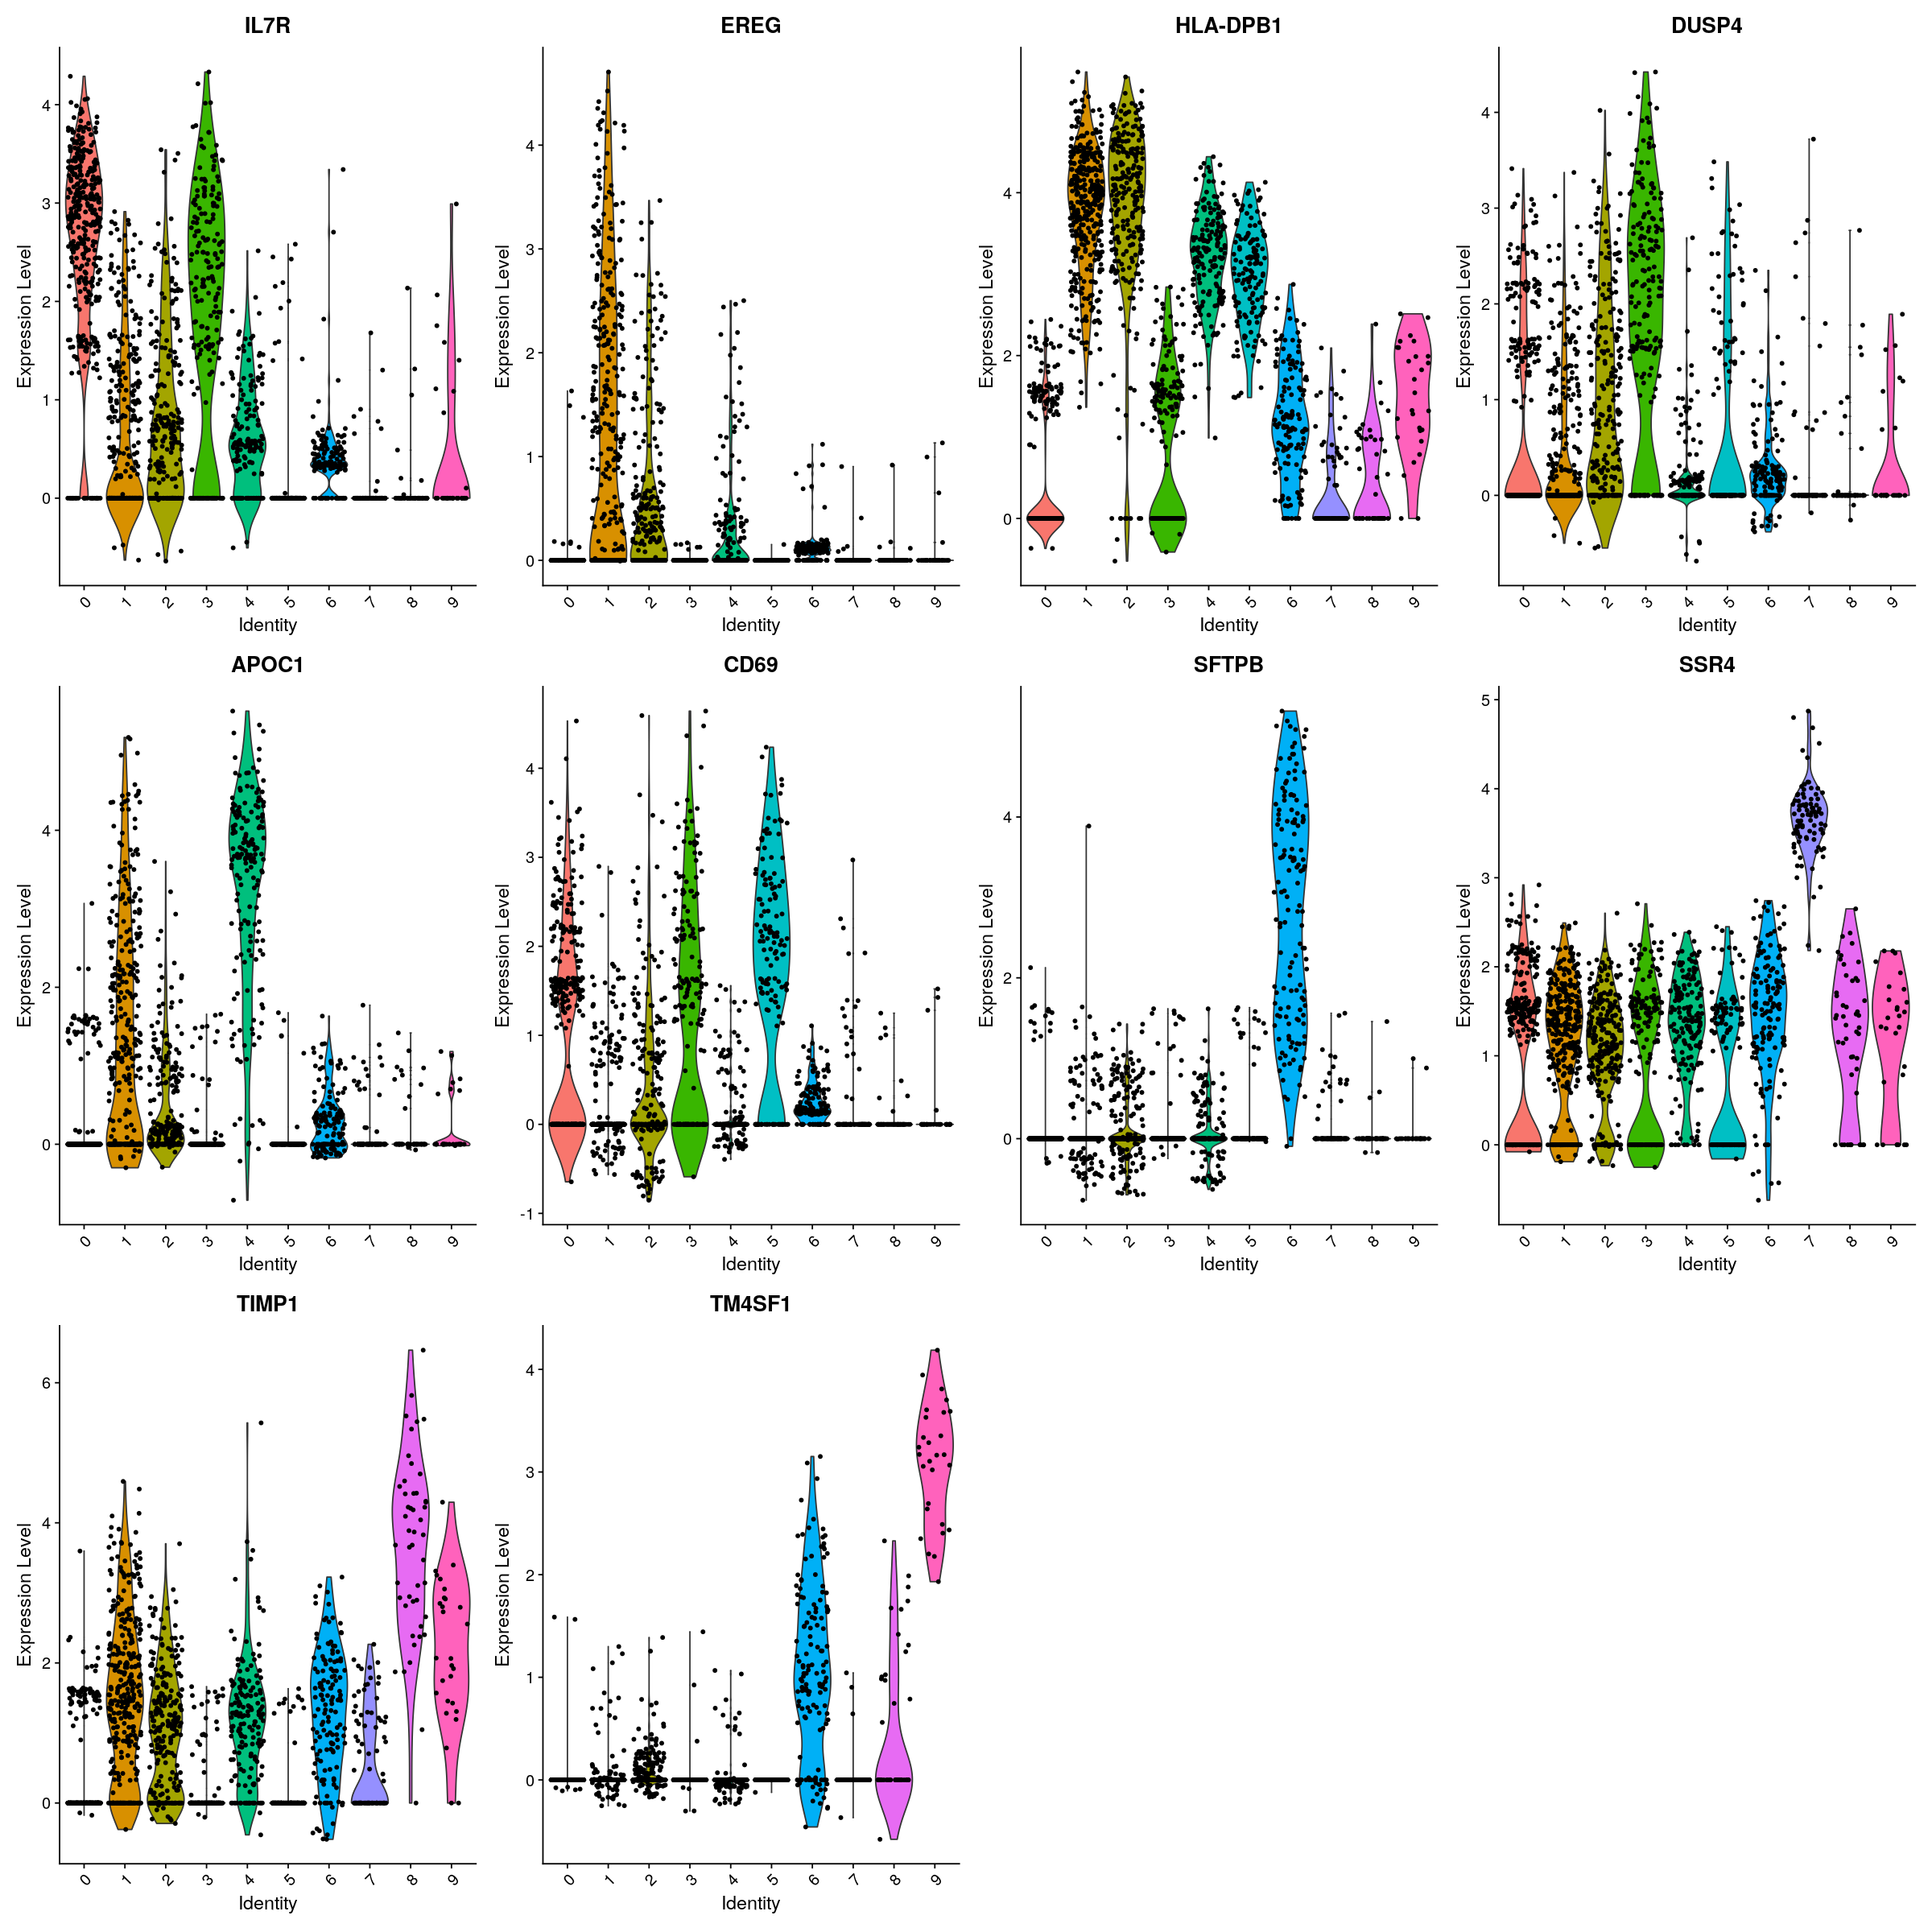

In [46]:
options(repr.plot.width=20, repr.plot.height=20)
top1 <- DEGs %>% group_by(cluster) %>% top_n(n = 1, wt = avg_logFC)
VlnPlot(seurat_object, features = top1$gene)

Picking joint bandwidth of 0.163



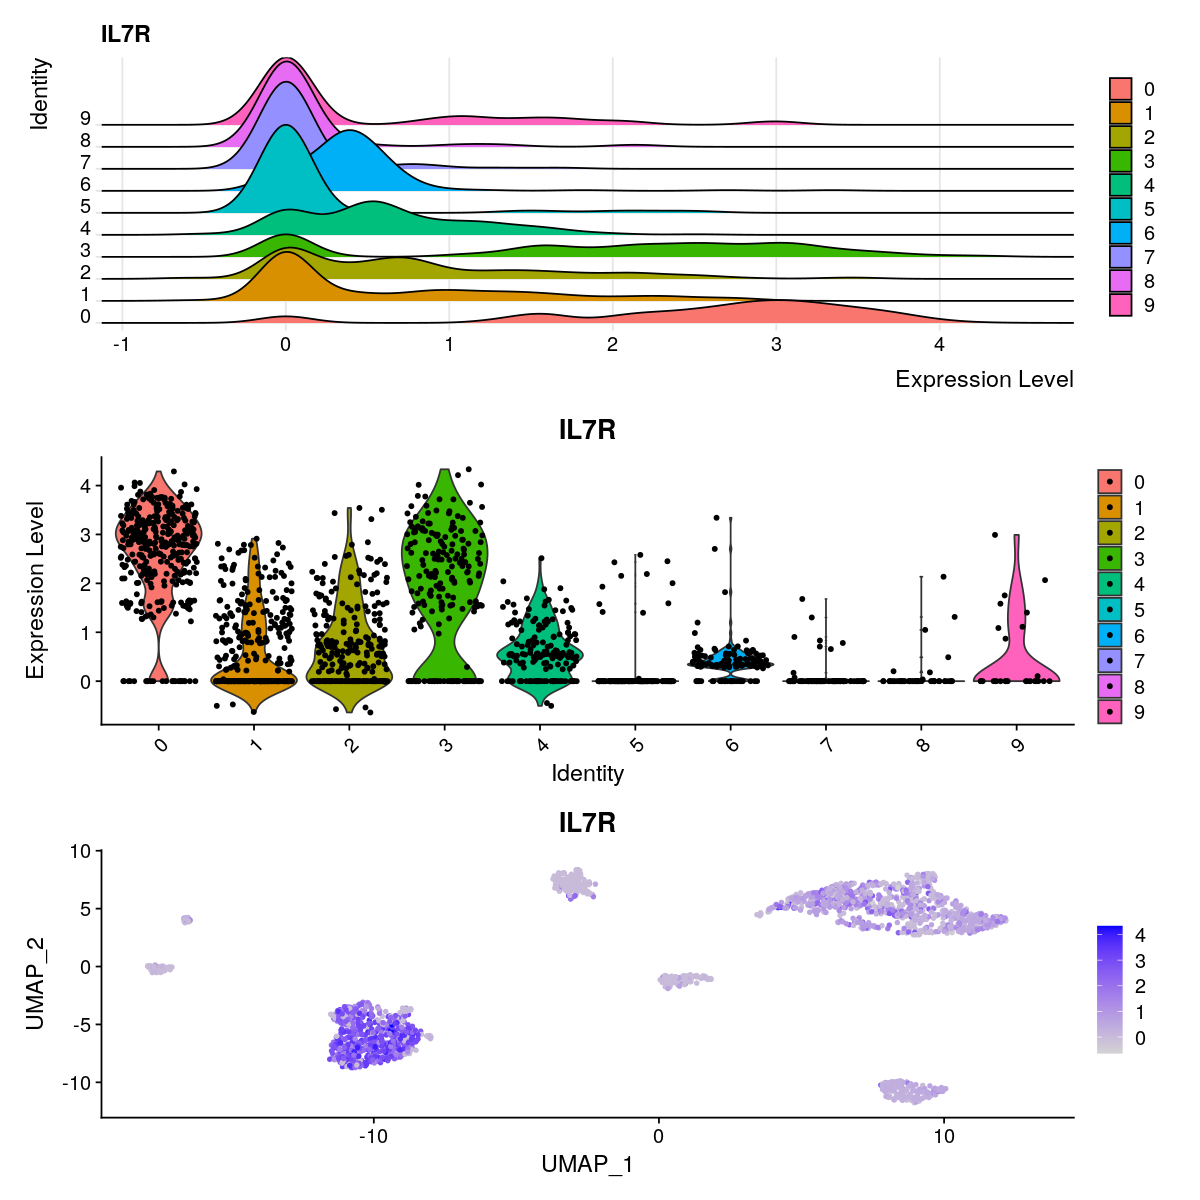

In [47]:
options(repr.plot.width=10, repr.plot.height=10)
plot1 <- RidgePlot(seurat_object, features = c("IL7R"))
plot2 <- VlnPlot(seurat_object, features = c("IL7R"))
plot3 <- FeaturePlot(seurat_object, features = c("IL7R"))
plot1 + plot2 + plot3

In [48]:
save(file = "seurat_object_lung_cancer.RData", seurat_object)

### I'm not able to install "Singler" and "celldex" packages here, so I do the cell annotation locally.
here is the code I use to annotate cells, and heatmap plot
Same package is used for annotation
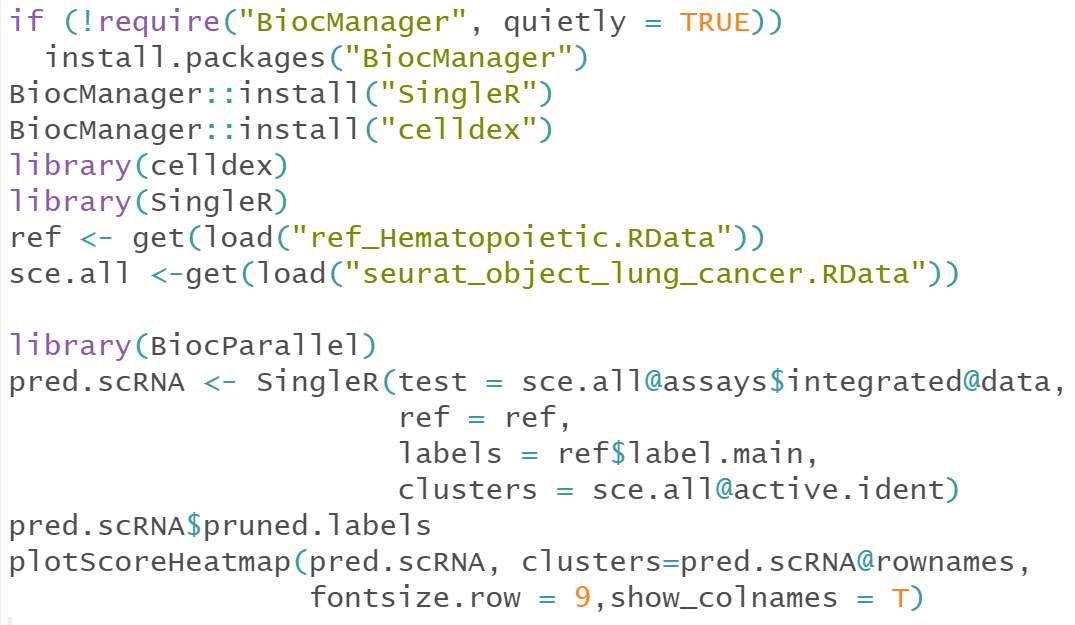

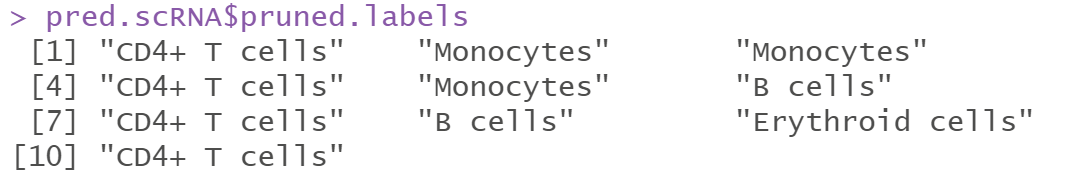

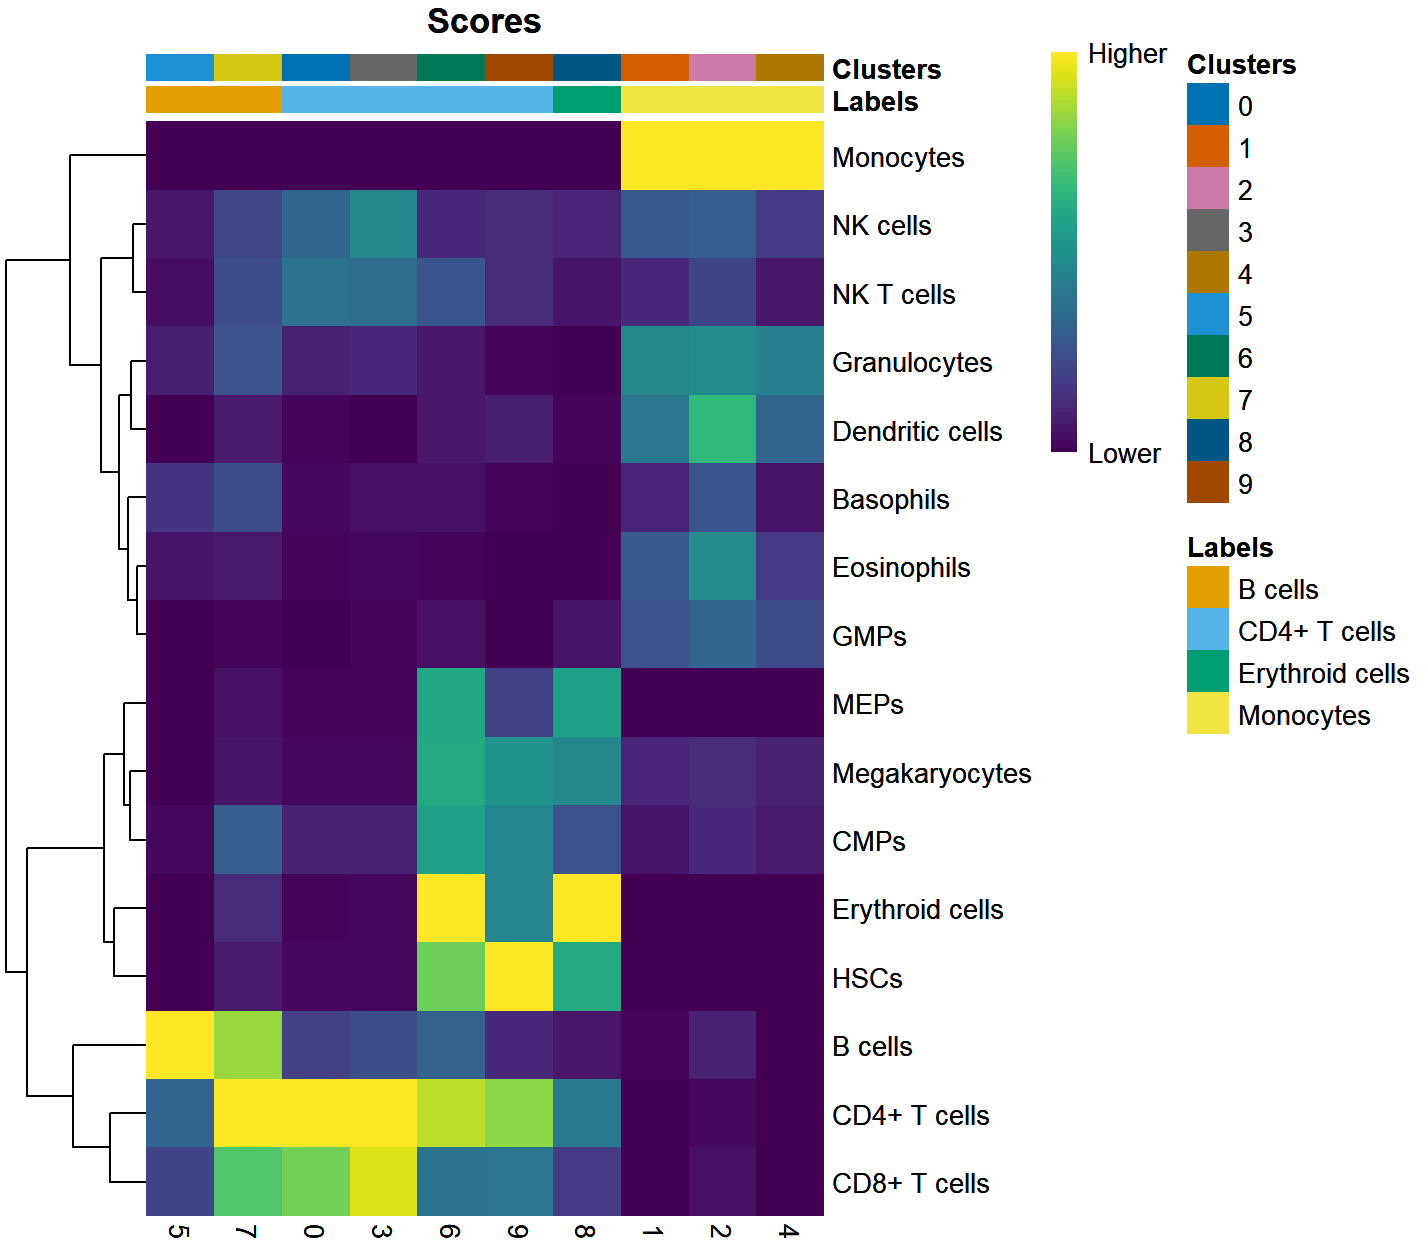

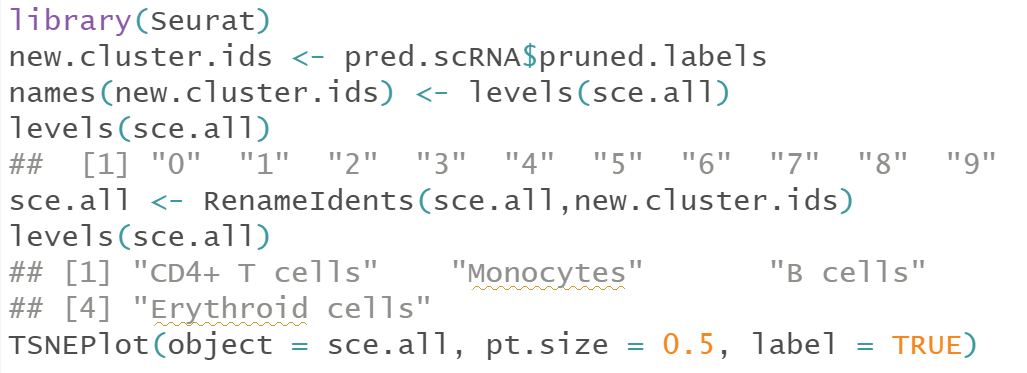

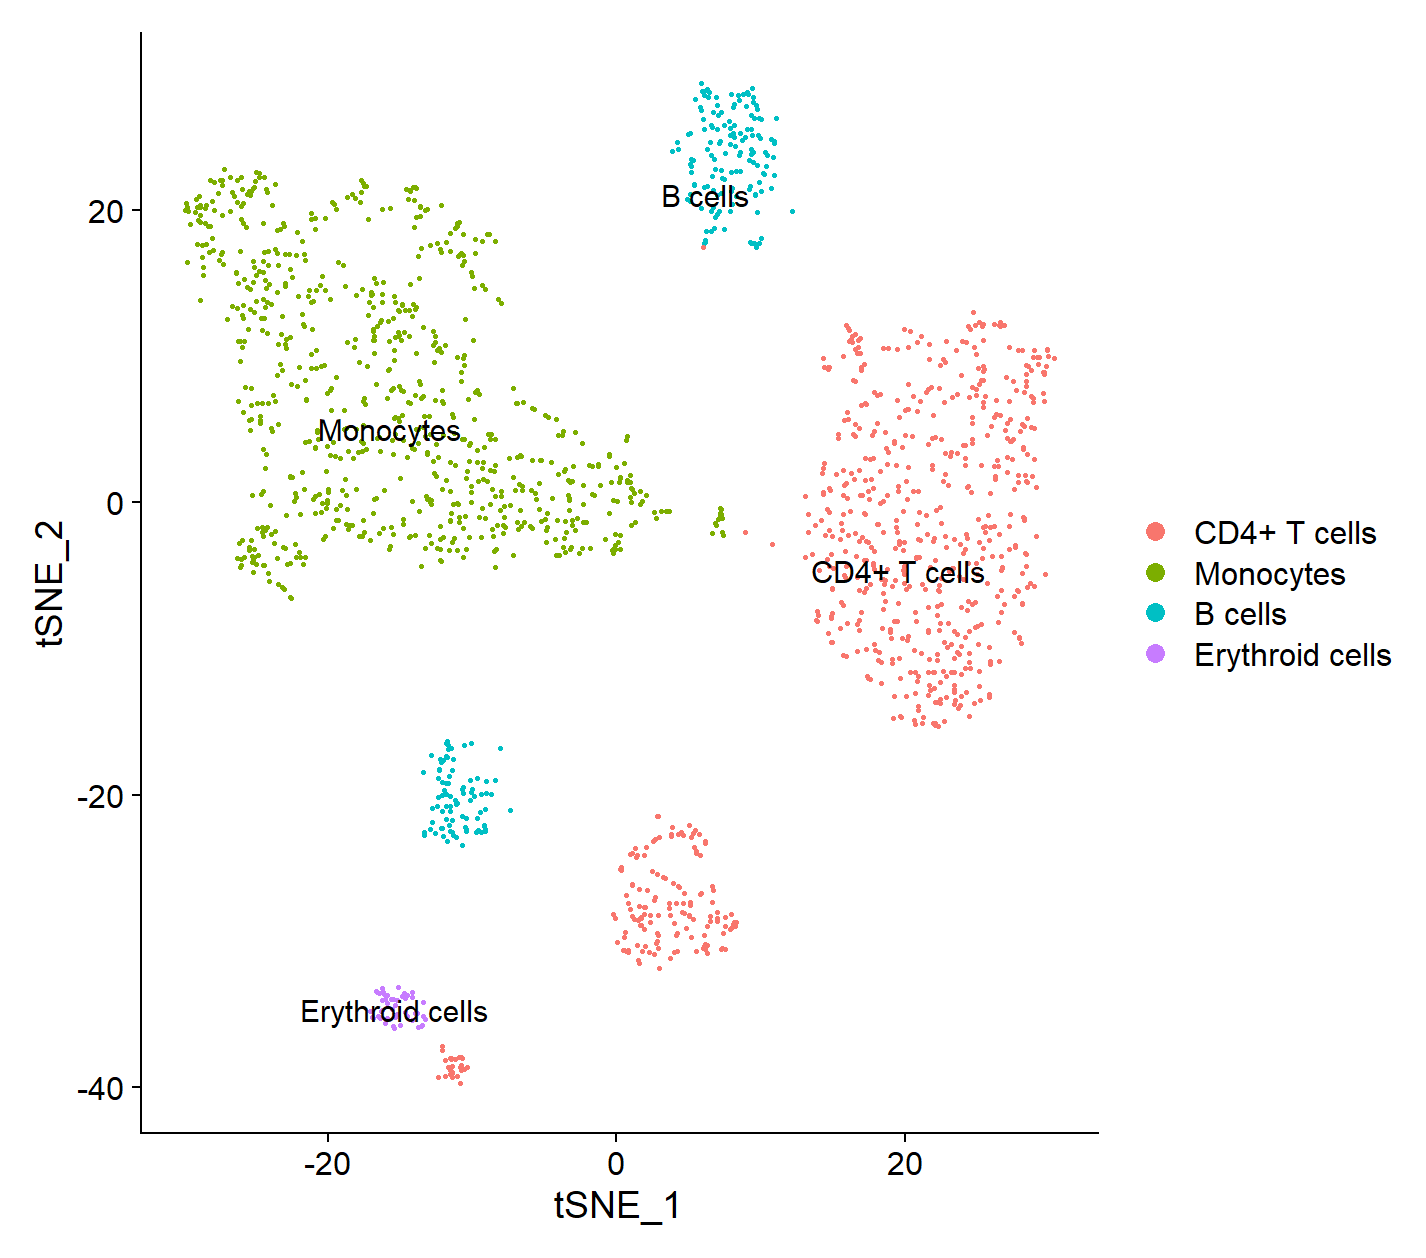

### There are 4 cell types have been identified here: CD4+ T cells, Monocytes, B cells and Erythroid cells
which is less than parper

### This is the cell types annotation from the paper, with no Erythroid cells but Macrophage and two cancer cells
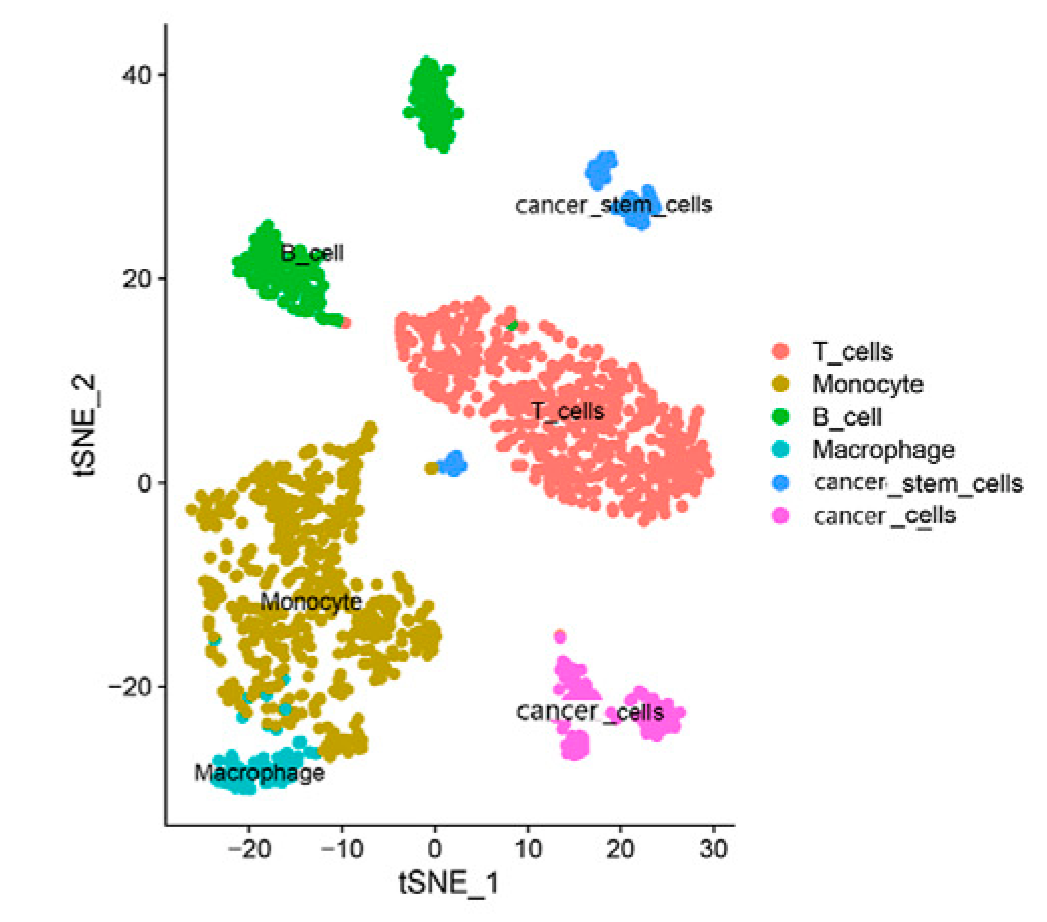

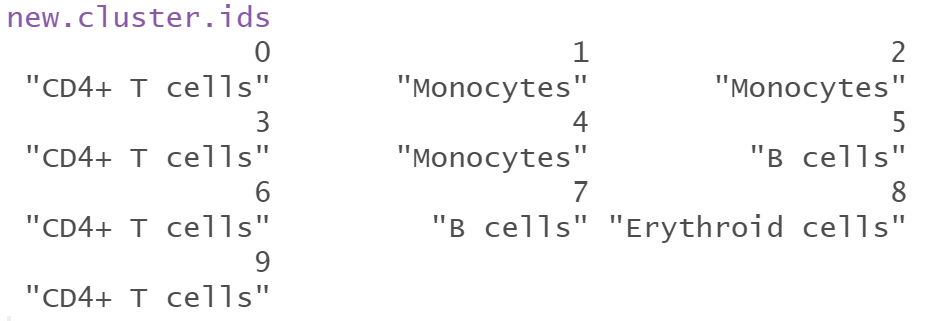
### Based on the results before, we can sum of the cells in different cluster with the same cell types

In [50]:
head(seurat_object[[]])

orig.ident nCount_RNA nFeature_RNA percent.mt AllData
AAACCTGGTACAGACG-1_1 GSM3304007  4338      1224         2.512679   AllData
AAACGGGGTAGCGCTC-1_1 GSM3304007 11724      2456         2.021494   AllData
AAACGGGGTCCTCTTG-1_1 GSM3304007  3353       726         2.117507   AllData
AAACGGGTCCAAACAC-1_1 GSM3304007  2811       986         2.312344   AllData
AAACGGGTCTTTAGTC-1_1 GSM3304007  6095      1590         3.002461   AllData
AAAGATGCATCTACGA-1_1 GSM3304007  7683      2049         2.824418   AllData
                     integrated_snn_res.0.6 integrated_snn_res.1
AAACCTGGTACAGACG-1_1 1                      4                   
AAACGGGGTAGCGCTC-1_1 8                      10                  
AAACGGGGTCCTCTTG-1_1 0                      0                   
AAACGGGTCCAAACAC-1_1 3                      2                   
AAACGGGTCTTTAGTC-1_1 1                      4                   
AAAGATGCATCTACGA-1_1 9                      11                  
                     integrated_snn_res.2 seurat_clusters
AAACCTGGTACAGACG-1_1 2                    2              
AAACGGGGTAGCGCTC-1_1 14                   14             
AAACGGGGTCCTCTTG-1_1 7                    7              
AAACGGGTCCAAACAC-1_1 1                    1              
AAACGGGTCTTTAGTC-1_1 2                    2              
AAAGATGCATCTACGA-1_1 15                   15

In [51]:
seurat_object[["cell_type"]] <- Idents(seurat_object)
head(seurat_object[[]])

orig.ident nCount_RNA nFeature_RNA percent.mt AllData
AAACCTGGTACAGACG-1_1 GSM3304007  4338      1224         2.512679   AllData
AAACGGGGTAGCGCTC-1_1 GSM3304007 11724      2456         2.021494   AllData
AAACGGGGTCCTCTTG-1_1 GSM3304007  3353       726         2.117507   AllData
AAACGGGTCCAAACAC-1_1 GSM3304007  2811       986         2.312344   AllData
AAACGGGTCTTTAGTC-1_1 GSM3304007  6095      1590         3.002461   AllData
AAAGATGCATCTACGA-1_1 GSM3304007  7683      2049         2.824418   AllData
                     integrated_snn_res.0.6 integrated_snn_res.1
AAACCTGGTACAGACG-1_1 1                      4                   
AAACGGGGTAGCGCTC-1_1 8                      10                  
AAACGGGGTCCTCTTG-1_1 0                      0                   
AAACGGGTCCAAACAC-1_1 3                      2                   
AAACGGGTCTTTAGTC-1_1 1                      4                   
AAAGATGCATCTACGA-1_1 9                      11                  
                     integrated_snn_res.2 seurat_clusters cell_type
AAACCTGGTACAGACG-1_1 2                    2               1        
AAACGGGGTAGCGCTC-1_1 14                   14              8        
AAACGGGGTCCTCTTG-1_1 7                    7               0        
AAACGGGTCCAAACAC-1_1 1                    1               3        
AAACGGGTCTTTAGTC-1_1 2                    2               1        
AAAGATGCATCTACGA-1_1 15                   15              9

In [52]:
seurat_object$cell_type <- ifelse(seurat_object$integrated_snn_res.0.6 %in% c(0, 3, 6, 9), "CD4+ T cells",
                            ifelse(seurat_object$integrated_snn_res.0.6 %in% c(1, 2, 4), "Monocytes",
                                   ifelse(seurat_object$integrated_snn_res.0.6 %in% c(5, 7), "B cells",
                                          ifelse(seurat_object$integrated_snn_res.0.6 == 8, "Erythroid cells", NA))))
head(seurat_object[[]])
sum(is.na(seurat_object$cell_type))

orig.ident nCount_RNA nFeature_RNA percent.mt AllData
AAACCTGGTACAGACG-1_1 GSM3304007  4338      1224         2.512679   AllData
AAACGGGGTAGCGCTC-1_1 GSM3304007 11724      2456         2.021494   AllData
AAACGGGGTCCTCTTG-1_1 GSM3304007  3353       726         2.117507   AllData
AAACGGGTCCAAACAC-1_1 GSM3304007  2811       986         2.312344   AllData
AAACGGGTCTTTAGTC-1_1 GSM3304007  6095      1590         3.002461   AllData
AAAGATGCATCTACGA-1_1 GSM3304007  7683      2049         2.824418   AllData
                     integrated_snn_res.0.6 integrated_snn_res.1
AAACCTGGTACAGACG-1_1 1                      4                   
AAACGGGGTAGCGCTC-1_1 8                      10                  
AAACGGGGTCCTCTTG-1_1 0                      0                   
AAACGGGTCCAAACAC-1_1 3                      2                   
AAACGGGTCTTTAGTC-1_1 1                      4                   
AAAGATGCATCTACGA-1_1 9                      11                  
                     integrated_snn_res.2 seurat_clusters cell_type      
AAACCTGGTACAGACG-1_1 2                    2               Monocytes      
AAACGGGGTAGCGCTC-1_1 14                   14              Erythroid cells
AAACGGGGTCCTCTTG-1_1 7                    7               CD4+ T cells   
AAACGGGTCCAAACAC-1_1 1                    1               CD4+ T cells   
AAACGGGTCTTTAGTC-1_1 2                    2               Monocytes      
AAAGATGCATCTACGA-1_1 15                   15              CD4+ T cells

[1] 0

In [53]:
table(seurat_object$cell_type)


        B cells    CD4+ T cells Erythroid cells       Monocytes 
            234             735              48             779 

### A total of 735 cells in cluster 0,3,6,9 were annotated as CD4+ T cells, 779 cells in clusters 1 and 2 as monocytes, 234 cells in clusters 5 and 7 as B cells, 48 cells in cluster 8 as Erythroid cells.

## Functional Analysis of DEGs

In [54]:
genesByCluster = split(DEGs$gene, DEGs$cluster)
# Number of genes by cluster:
cbind(lengths(genesByCluster))

[,1]
0  62 
1 360 
2 161 
3 116 
4 387 
5  51 
6 417 
7  70 
8 470 
9 317

In [55]:
DEGs_CD4vsMonocytes_ranking <- FindMarkers(seurat_object, ident.1 = c(0,3,6,9), ident.2 = c(1,2,4), 
                                     only.pos = FALSE, min.pct=0, logfc.threshold=0)

In [56]:
nrow(DEGs_CD4vsMonocytes_ranking)
head(DEGs_CD4vsMonocytes_ranking)

[1] 2000

p_val         avg_logFC pct.1 pct.2 p_val_adj    
TYROBP   1.103438e-246 -2.932726 0.269 0.991 2.206876e-243
HLA-DRA  1.966602e-239 -3.166733 0.521 0.990 3.933203e-236
HLA-DPA1 3.003277e-237 -2.628482 0.371 0.983 6.006555e-234
HLA-DPB1 9.883862e-235 -2.837818 0.486 0.987 1.976772e-231
CD74     1.222507e-229 -2.594028 0.690 0.994 2.445014e-226
FCER1G   6.690846e-225 -2.369081 0.215 0.953 1.338169e-221

In [57]:
DEGs_CD4vsMonocytes_ranking$gene <- rownames(DEGs_CD4vsMonocytes_ranking)
write.table(DEGs_CD4vsMonocytes_ranking, file = "DEGs_CD4vsMonocytes_ranking.txt", sep="\t", quote=F, col.names=T, row.names=F)

In [58]:
head(seurat_object[[]])

orig.ident nCount_RNA nFeature_RNA percent.mt AllData
AAACCTGGTACAGACG-1_1 GSM3304007  4338      1224         2.512679   AllData
AAACGGGGTAGCGCTC-1_1 GSM3304007 11724      2456         2.021494   AllData
AAACGGGGTCCTCTTG-1_1 GSM3304007  3353       726         2.117507   AllData
AAACGGGTCCAAACAC-1_1 GSM3304007  2811       986         2.312344   AllData
AAACGGGTCTTTAGTC-1_1 GSM3304007  6095      1590         3.002461   AllData
AAAGATGCATCTACGA-1_1 GSM3304007  7683      2049         2.824418   AllData
                     integrated_snn_res.0.6 integrated_snn_res.1
AAACCTGGTACAGACG-1_1 1                      4                   
AAACGGGGTAGCGCTC-1_1 8                      10                  
AAACGGGGTCCTCTTG-1_1 0                      0                   
AAACGGGTCCAAACAC-1_1 3                      2                   
AAACGGGTCTTTAGTC-1_1 1                      4                   
AAAGATGCATCTACGA-1_1 9                      11                  
                     integrated_snn_res.2 seurat_clusters cell_type      
AAACCTGGTACAGACG-1_1 2                    2               Monocytes      
AAACGGGGTAGCGCTC-1_1 14                   14              Erythroid cells
AAACGGGGTCCTCTTG-1_1 7                    7               CD4+ T cells   
AAACGGGTCCAAACAC-1_1 1                    1               CD4+ T cells   
AAACGGGTCTTTAGTC-1_1 2                    2               Monocytes      
AAAGATGCATCTACGA-1_1 15                   15              CD4+ T cells

### Since I didn't produce the same result as the paper. Especially no cancer cells identified, we just focus on the cell types I own based on my result
Since the number of differential expressed genes are relatively small in each cluster, here we decide to compare two major cell types in these cells, which are CD4+ Tcell and Monocytes.


## Exporting a Seurat object to a loom file

In [59]:
loom <- build_loom(file.name = "lung_cancer.loom", 
                        dgem = as.matrix(seurat_object[["RNA"]]@counts),
                        title = "Lung Cancer Dataset",
                        genome="Human",
                        default.embedding = seurat_object@reductions$umap@cell.embeddings,
                        default.embedding.name = "Umap")

[1] "Adding global attributes..."
[1] "Adding matrix..."
  |======================================================================| 100%[1] "Adding column attributes..."
[1] "Adding default metrics nUMI..."
[1] "Adding default metrics nGene..."
[1] "Adding default embedding..."
[1] "Adding row attributes..."
[1] "Adding columns graphs..."
[1] "Adding row graphs..."
[1] "Adding layers..."


In [60]:
marker_file_list <- list(integrated_snn_res.0.6 = "DEG.rds") # feel free to add more resolutions

add_seurat_clustering(loom, 
                      seurat = seurat_object,
                      seurat.assay = "RNA",
                      default.clustering.resolution = 0.6,
                      seurat.clustering.prefix = "integrated_snn_res.",
                      seurat.markers.file.path.list = marker_file_list)

[1] "Seurat, integrated_snn_res.0.6"
[1] "Adding Seurat clusters..."
[1] "Adding default Seurat clusters..."
[1] "Clusterings created..."
[1] "Clustering ID: 0"
[1] "Adding Seurat markers..."
[1] "Adding markers for clustering 0..."
[1] "Seurat, integrated_snn_res.1"
[1] "Adding Seurat clusters..."
[1] "Clusterings already exists..."
[1] "Clustering ID: 1"
[1] "Adding Seurat markers..."


Warning message in add_seurat_clustering(loom, seurat = seurat_object, seurat.assay = "RNA", :
“Seurat markers for clustering resolution 1 have not been computed.”


[1] "Seurat, integrated_snn_res.2"
[1] "Adding Seurat clusters..."
[1] "Clusterings already exists..."
[1] "Clustering ID: 2"
[1] "Adding Seurat markers..."


Warning message in add_seurat_clustering(loom, seurat = seurat_object, seurat.assay = "RNA", :
“Seurat markers for clustering resolution 2 have not been computed.”


In [61]:
colnames(seurat_object[[]])

[1] "orig.ident"             "nCount_RNA"             "nFeature_RNA"          
 [4] "percent.mt"             "AllData"                "integrated_snn_res.0.6"
 [7] "integrated_snn_res.1"   "integrated_snn_res.2"   "seurat_clusters"       
[10] "cell_type"

In [62]:
for(keyName in c('nCount_RNA', 'percent.mt'))
{
    message('Adding', keyName, '...')
    add_col_attr(loom, key = keyName,
                value = as.vector(seurat_object[[keyName]][,1]),
                as.annotation = FALSE)
}

AddingnCount_RNA...

Addingpercent.mt...



In [65]:
for(keyName in c('orig.ident', 'cell_type'))
{
    message('Adding', keyName, '...')
    add_col_attr(loom, key = keyName,
                value = as.vector(seurat_object[[keyName]][,1]),
                as.annotation = TRUE)
}


Addingorig.ident...

Addingcell_type...



In [66]:
finalize(loom)

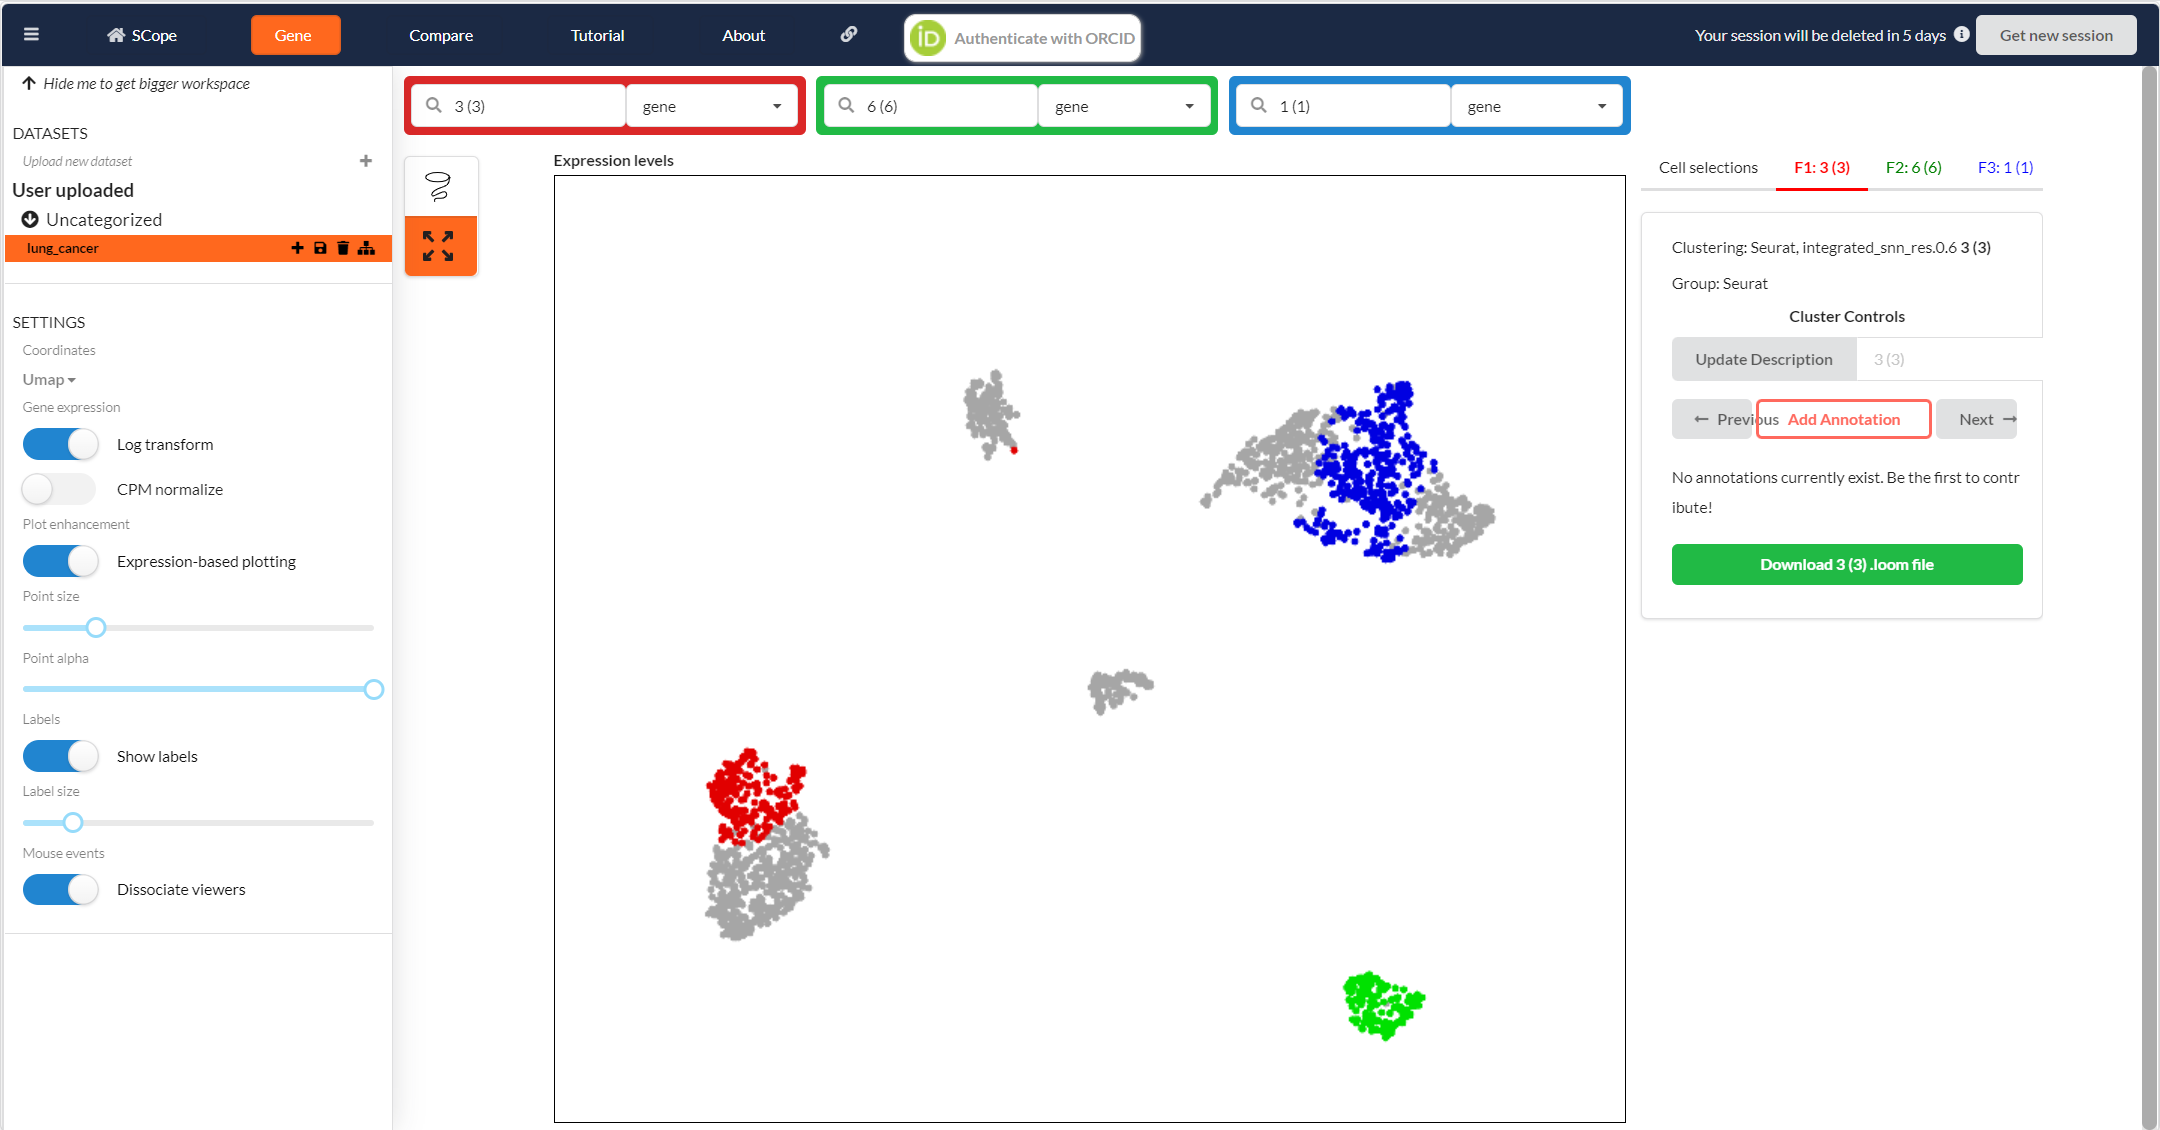

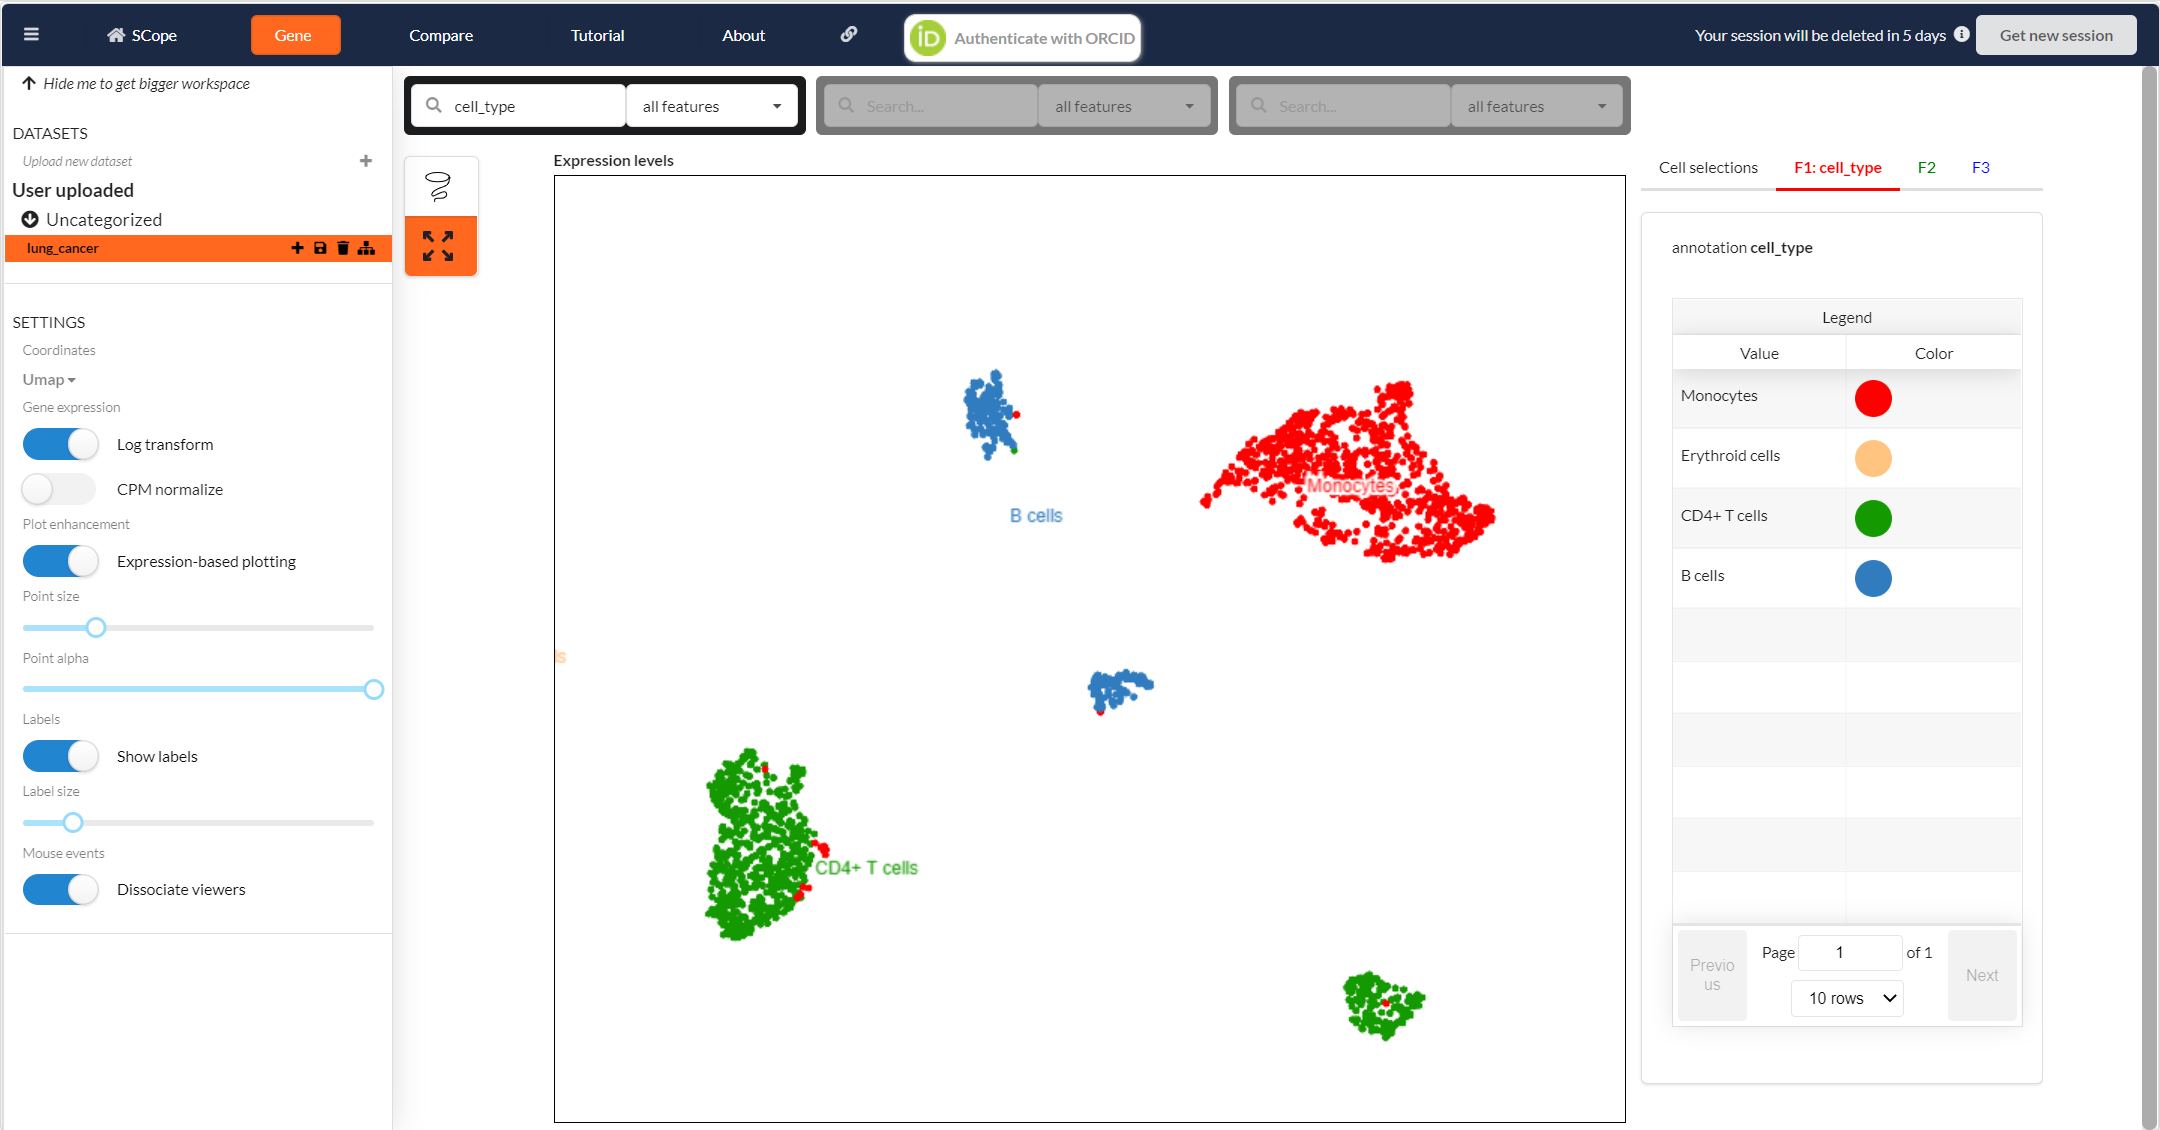

In [67]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] stringr_1.4.1     patchwork_1.1.2   plyr_1.8.7        IRdisplay_1.1    
[5] SCopeLoomR_0.10.1 Matrix_1.2-18     dplyr_1.0.10      Seurat_3.2.2     

loaded via a namespace (and not attached):
  [1] Rtsne_0.16           colorspace_2.0-3     rjson_0.2.20        
  [

# Summary

The same data as paper used for scRNA-seq analysis was used here but I didn't manage to reproduce the result as the parper have. It might due to some reasons:

(1) After quality control, I got 1795 versus 1695 cells in paper, we may use different method to integrate multiple data. It could be that they used more strict criteria to remove those cells with relatively low quality to reach a better result.
    
(2) During the quality control, I chosed to remove those with 25% feature counts, all of which are from one patient(GSM3304007) as we can see from the plot before. And although around 80% cells have lower than 20,000, those cells with higher counts, of course, contain more information, I removed to focus more on cells cluster together. In this case, a great proportion of cells in one patient(GSM3304011) will be removed, which may also explain the different result, especially the cell annotation I got.
    
(3) in count matrix based on the cluster, the cluster 0 and 5 with 99% are very likely to be the cancel cell types, but they were annotated as CD4+ Tcells and B cells separately. Maybe I need to find the 1% cell in cluster 0 and 5, and remove them then do the annotation again, but I don't know how to do it at the moment.

Anyway, in my result, all cells were classified into 10 clusters and finally 4 cell types(CD4+ Tcells, Monocytes, Erythroid cells and B cells) were annotated by package 'SingleR'.
Since there was no cancer cells, and all of three patients are cancer patients, I'm not able to compare cancer cell with normal cells to find those potential genes that are highly responsible for lung cancer.

So I continued here and try to do functional analysis for differences gene expression between most two major cell types here(CD4+ Tcells and Monocytes).